# API

In [112]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [113]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [121]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from Chern_insulator import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [120]:
# %%writefile Chern_insulator.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib


class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            Delta=1,
            t=1,
            m=1,
            bcx=-1,
            bcy=1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.Delta = Delta
        self.t = t
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(np.eye(Ly),hopx)
            hopymat = np.kron(hopy,np.eye(Lx))
            self.hopxmat=hopxmat
            self.hopymat=hopymat
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay))* 1j*Delta-t*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf:
            self.dxmax=dxmax
            self.dymax=dymax
            self.dx=lambda kx: Delta*np.sin(kx)
            self.dy=lambda ky: Delta*np.sin(ky)
            self.dz=lambda kx,ky: m-t*np.cos(kx)-t*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))
            

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist_k(self,kx,ky,branch,E_F=0):
        if self.T==0:
            return np.heaviside(E_F-self.E_k(kx,ky,branch),0)
        else:
            return 1/(1+np.exp((self.E_k(kx,ky,branch)-E_F)/self.T))

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix_inf_fft(self,threshold=[1024,512]):
        '''
        self.dxmax/self.dymax: the maximal distance in x/y direction (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.Lx==np.inf and self.Ly==np.inf, "Wire length should be inf"
        # cov_mat=[]
        Nxmax=max(2*self.dxmax,threshold[0])
        Nymax=max(2*self.dymax,threshold[1])
        if self.T>0:
            pass    #to be filled
        else:
            kxlist=np.arange(0,2*np.pi,2*np.pi/Nxmax)
            kylist=np.arange(0,2*np.pi,2*np.pi/Nymax)
            kxmap,kymap=np.meshgrid(kxlist,kylist)
            dxmap=self.dx(kxmap)
            dymap=self.dy(kymap)
            dzmap=self.dz(kxmap,kymap)
            Ekmap=np.sqrt(dxmap**2+dymap**2+dzmap**2)
            Ekxymap=np.sqrt(dxmap**2+dymap**2)
            costheta=dzmap/Ekmap
            sintheta=Ekxymap/Ekmap
            Ekxymap[0,0]=np.inf #to avoid 0/0 in cos(phi) & sin(phi); the order of this line matters
            cosphi=dxmap/Ekxymap
            sinphi=dymap/Ekxymap
            fftcostheta=np.fft.ifft2(costheta)
            constmap=np.zeros((Nymax,Nxmax))
            constmap[0,0]=0.5
            A_11=constmap-fftcostheta/2
            A_22=constmap+fftcostheta/2
            A_12=np.fft.ifft2(-(cosphi-1j*sinphi)/2*sintheta)
            A_21=np.fft.ifft2(-(cosphi+1j*sinphi)/2*sintheta)
            mat=np.stack([[A_11,A_12],[A_21,A_22]])
            C_f=np.zeros((2*self.dxmax*self.dymax,2*self.dxmax*self.dymax))*1j
            for i in range(self.dxmax*self.dymax):
                for j in range(i):
                    ix,iy=i%self.dxmax,i//self.dxmax
                    jx,jy=j%self.dxmax,j//self.dxmax
                    dx,dy=(ix-jx)%Nxmax,(iy-jy)%Nymax
                    C_f[2*i:2*i+2,2*j:2*j+2]=mat[:,:,dy,dx]
            C_f=C_f+C_f.T.conj()
            for i in range(self.dxmax*self.dymax):
                C_f[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0,0]
            self.C_f=C_f

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False, k=2):
        '''
        If proj ==True, then the index used for projection operator will be returned
        k, the size of measurement, is useful only when proj=True
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            assert subregion_x.max()<self.Lx and subregion_y.max()<self.Ly, 'Range exceeds'
            linear_index = ((X+Y*self.Lx).flatten('F'))
        else:
            assert subregion_x.max()<self.dxmax and subregion_y.max()<self.dymax, 'Range exceeds'
            linear_index = ((X+Y*self.dxmax).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, k)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def square_index(self, subregion):
        subregion=np.unique(np.array(subregion)//4)
        if self.Lx<np.inf and self.Ly<np.inf:
            return subregion%self.Lx,subregion//self.Lx
        else:
            return subregion%self.dxmax,subregion//self.dxmax


    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 4)
            subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s,type='onsite'):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        if type=='onsite':
            assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
            blkmat = np.array([[0, -(-1)**s, 0, 0],
                            [(-1)**s, 0, 0, 0],
                            [0, 0, 0, (-1)**s],
                            [0, 0, -(-1)**s, 0]])
            return blkmat
        if type=='link':
            assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
            if s=='o+':
                antidiag=[1,-1,1,-1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if s=='o-':
                antidiag=[-1,1,-1,1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if s=='e+':
                blkmat=np.array([[0,-1,0,0],
                                 [1,0,0,0],
                                 [0,0,0,-1],
                                 [0,0,1,0]])
            if s=='e-':
                blkmat=-np.array([[0,-1,0,0],
                                 [1,0,0,0],
                                 [0,0,0,-1],
                                 [0,0,1,0]])
            # if s=='e+':
            #     antidiag=[-1,-1,1,1]
            #     blkmat=np.diag(antidiag)
            #     blkmat=np.fliplr(blkmat)
            # if s=='e-':
            #     antidiag=[1,1,-1,-1]
            #     blkmat=np.diag(antidiag)
            #     blkmat=np.fliplr(blkmat)
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj            
        raise ValueError("type '{}' is not defined".format(type))

    def measure(self, s, ix,type='onsite'):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s,type=type)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None,linear=False,type='onsite',pool=4):
        if not linear:
            if type=='onsite':
                proj_range = self.linearize_index(proj_range, 4, proj=True)
            if type=='link':
                proj_range = self.linearize_index(proj_range, 4, proj=True,k=4)
        # self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if type=='onsite':
            for i in proj_range:
                if prob is None:
                    P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
                else:
                    P_0=prob
                self.P_0_list.append(P_0)
                if np.random.rand() < P_0:
                    self.measure(0, [i, i+1])
                    self.f_parity.append(0)
                else:
                    self.measure(1, [i, i+1])
                    self.f_parity.append(1)
            return self

        if type=='link':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                P={}
                gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
                if prob is None:
                    P['o+']=(1+Gamma[1,2]-Gamma[0,3]+gamma1234)/4
                    P['o-']=(1-Gamma[1,2]+Gamma[0,3]+gamma1234)/4
                    P['e+']=(1+Gamma[0,1]+Gamma[2,3]-gamma1234)/4
                    P['e-']=(1-Gamma[0,1]-Gamma[2,3]-gamma1234)/4
                else:
                    P['o+'],P['o-'],P['e+'],P['e-']=tuple(prob)
                #ignore symmetry
                # P['e+']=(1+Gamma[1,2]+Gamma[0,3]-gamma1234)/4
                # P['e-']=(1-Gamma[1,2]-Gamma[0,3]-gamma1234)/4
                # print((P.values()))
                if pool==4:
                    s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
                elif pool==2:
                    s=np.random.choice(['o+','o-'],p=[P['o+']/(P['o+']+P['o-']),P['o-']/(P['o+']+P['o-'])])
                elif pool==-2:
                    s=np.random.choice(['e+','e-'],p=[P['e+']/(P['e+']+P['e-']),P['e-']/(P['e+']+P['e-'])])
                self.measure(s,[i,i+1,i+2,i+3],type='link')
            return self

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

# Test

In [22]:
params=Params(m=1,Lx=16,Ly=16,bcx=-1,bcy=1)
params.covariance_matrix()

In [26]:
params_inf=Params(m=1,dxmax=32,dymax=8,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
params_inf.covariance_matrix()

In [13]:
print(np.round(params.C_m[0,:],10))

[ 0.          0.49116916  0.         ...  0.11674754 -0.05804682
 -0.05804711]


In [14]:
print(np.round(params_inf.C_m[0,:],10))

[ 0.          0.49116916 -0.         ...  0.          0.
  0.        ]


In [27]:
zz=params_inf.C_f[0,params_inf.linearize_index([np.arange(params_inf.dxmax),[0]],2)[::2]]

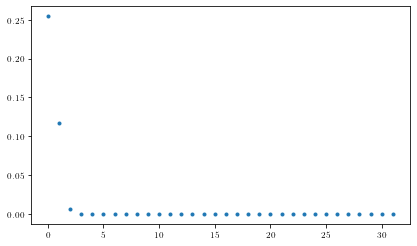

In [28]:
fig,ax=plt.subplots()
ax.plot((np.real(zz)),'.')
# ax.set_yscale('log')


In [29]:
zz[0]*np.exp(-1)

(0.09359420287284982+0j)

In [22]:
(np.real(zz))

array([ 2.54415421e-01,  1.16747537e-01,  6.41448147e-03,  2.99788409e-04,
       -2.52361529e-04, -1.96112518e-04, -1.10247922e-04, -5.65751865e-05,
       -2.79866496e-05, -1.36110432e-05, -6.56462509e-06, -3.15330569e-06,
       -1.51199005e-06, -7.24619032e-07, -3.47347370e-07, -1.66607249e-07])

In [103]:
Gmat_real_jl=np.loadtxt('Gmat_real.txt')

In [104]:
Gmat_imag_jl=np.loadtxt('Gmat_imag.txt')

In [105]:
np.abs(Gmat_imag_jl*1j+Gmat_real_jl-params.C_m).max()

4.409667097410358e-15

In [48]:
np.round(np.real(params.C_f[:8,:8]),3)

array([[ 0.254, -0.   ,  0.117, -0.   ,  0.006,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.746,  0.   , -0.117, -0.   , -0.006, -0.   , -0.   ],
       [ 0.117,  0.   ,  0.254,  0.   ,  0.117, -0.   ,  0.006,  0.   ],
       [-0.   , -0.117,  0.   ,  0.746, -0.   , -0.117, -0.   , -0.006],
       [ 0.006, -0.   ,  0.117, -0.   ,  0.254, -0.   ,  0.117,  0.   ],
       [ 0.   , -0.006, -0.   , -0.117, -0.   ,  0.746, -0.   , -0.117],
       [ 0.   , -0.   ,  0.006, -0.   ,  0.117, -0.   ,  0.254,  0.   ],
       [-0.   , -0.   ,  0.   , -0.006,  0.   , -0.117,  0.   ,  0.746]])

In [29]:
params.C_m

array([[ 0.00000000e+00,  4.91281106e-01, -1.30269817e-17, ...,
         1.16896488e-01, -5.81927802e-02, -5.82094735e-02],
       [-4.91281106e-01,  0.00000000e+00, -4.99826028e-17, ...,
        -1.38779925e-17,  5.82094735e-02, -5.81927802e-02],
       [ 1.30269817e-17,  4.99826028e-17,  0.00000000e+00, ...,
         5.82094735e-02, -9.36750677e-17, -1.16896488e-01],
       ...,
       [-1.16896488e-01,  1.38779925e-17, -5.82094735e-02, ...,
         0.00000000e+00, -5.37764278e-17,  4.16333634e-17],
       [ 5.81927802e-02, -5.82094735e-02,  9.36750677e-17, ...,
         5.37764278e-17,  0.00000000e+00, -4.91281106e-01],
       [ 5.82094735e-02,  5.81927802e-02,  1.16896488e-01, ...,
        -4.16333634e-17,  4.91281106e-01,  0.00000000e+00]])

In [83]:
print(np.round(params.hopxmat,0))

[[ 0.  0.  0.  0.  0.  0. -1. -0. -0.]
 [ 0.  0.  0.  0.  0.  0. -0. -1. -0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]]


In [84]:
print(np.round(params.hopymat,0))

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [85]:
np.round(np.real(params.C_f[:8,:8]),3)

array([[ 0.254, -0.   ,  0.123,  0.   ,  0.123,  0.   ,  0.118,  0.189],
       [-0.   ,  0.746, -0.   , -0.123,  0.   , -0.123, -0.189, -0.118],
       [ 0.123, -0.   ,  0.254,  0.   ,  0.123, -0.   ,  0.066,  0.031],
       [ 0.   , -0.123,  0.   ,  0.746, -0.   , -0.123, -0.031, -0.066],
       [ 0.123,  0.   ,  0.123, -0.   ,  0.254, -0.   ,  0.066,  0.031],
       [ 0.   , -0.123, -0.   , -0.123, -0.   ,  0.746, -0.031, -0.066],
       [ 0.118, -0.189,  0.066, -0.031,  0.066, -0.031,  0.254, -0.   ],
       [ 0.189, -0.118,  0.031, -0.066,  0.031, -0.066, -0.   ,  0.746]])

In [74]:
np.round(np.real(params.C_f[0,:]),3)

array([ 0.254, -0.   ,  0.123,  0.   ,  0.123,  0.   ,  0.118,  0.189,
        0.066,  0.031,  0.066,  0.031, -0.118,  0.189, -0.066,  0.031,
       -0.066,  0.031])

In [79]:
np.round(np.real(params.C_m[:8,:8]),3)

array([[ 0.   ,  0.491, -0.   ,  0.   ,  0.   , -0.246, -0.274, -0.   ],
       [-0.491,  0.   , -0.   , -0.   ,  0.246,  0.   ,  0.   , -0.274],
       [ 0.   ,  0.   ,  0.   , -0.491, -0.274,  0.   ,  0.   ,  0.246],
       [-0.   ,  0.   ,  0.491,  0.   , -0.   , -0.274, -0.246,  0.   ],
       [-0.   , -0.246,  0.274,  0.   ,  0.   ,  0.491,  0.   , -0.   ],
       [ 0.246, -0.   , -0.   ,  0.274, -0.491,  0.   ,  0.   ,  0.   ],
       [ 0.274, -0.   , -0.   ,  0.246, -0.   , -0.   ,  0.   , -0.491],
       [ 0.   ,  0.274, -0.246, -0.   ,  0.   , -0.   ,  0.491,  0.   ]])

In [53]:
params.Hamiltonian

array([[ 1.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.-1.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  1.+0.j,  0.-1.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [-1.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.-1.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.-1.j,
         0.+0.j],
       [ 0.+0.j,  0.+1.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j, -1.+0.j,
         0.+0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
         1.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+1.j, -1.+0.j,  0.+0.j,  1.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+1.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
        -1.+0.j]])

In [77]:
np.imag(params.Hamiltonian[:8,:8])

array([[ 0. ,  0. ,  0. , -0.5,  0. ,  0.5,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0. , -0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [54]:
np.trace(params_L.C_f)

(63.999999999999986+0j)

In [20]:
np.fft.fftshift(np.arange(8))

array([4, 5, 6, 7, 0, 1, 2, 3])

In [22]:
(-1)%8

7

In [85]:
[np.arange(params_L.Lx//4),np.arange(params_L.Ly)]

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [86]:
[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)]

[array([16, 17, 18, 19, 20, 21, 22, 23]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [84]:
params_L.log_neg([np.arange(params_L.Lx//4),np.arange(params_L.Ly)],[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)])

1.1922531067298792e-05

In [43]:
params_L.eA,params_L.sA

((4.1663770577805295+1.3560409326122747e-07j), -4.162655047950205)

In [38]:
np.round(params_L.C_m[4:8,0:4],10)

array([[ 0.        , -0.23363533,  0.        ,  0.33322578],
       [ 0.23363533,  0.        , -0.33322578,  0.        ],
       [ 0.        , -0.33322578,  0.        ,  0.23363533],
       [ 0.33322578,  0.        , -0.23363533,  0.        ]])

In [28]:
params=Params(Lx=np.inf,Ly=np.inf,m=1,dxmax=32,dymax=8)

In [29]:
params.covariance_matrix()

In [30]:
np.trace(params.C_f)

(255.99999999999994+0j)

In [80]:
[np.arange(params.dxmax//4),np.arange(params.dymax)]

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [81]:
[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]

[array([16, 17, 18, 19, 20, 21, 22, 23]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [31]:
params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)])

4.939384544044856e-06

In [17]:
params.log_neg([np.arange(8),np.arange(params.dymax)],[np.arange(8)+16,np.arange(params.dymax)])

10.238806413941262

In [ ]:
list(np.diag(np.round(params.C_m@params.C_m,10)))

In [94]:
np.round(params_L.C_m@params_L.C_m,10)[:4,:4]

array([[-1., -0., -0.,  0.],
       [-0., -1.,  0., -0.],
       [-0.,  0., -1., -0.],
       [ 0., -0., -0., -1.]])

In [39]:
np.round(params.C_m[4:8,0:4],10)

array([[-0.        , -0.23349507,  0.        ,  0.33298183],
       [ 0.23349507, -0.        , -0.33298183,  0.        ],
       [-0.        , -0.33298183,  0.        ,  0.23349507],
       [ 0.33298183, -0.        , -0.23349507,  0.        ]])

In [45]:
params.eA,params.A

((10.622356289937139+0j), -6.282906951360542)

In [613]:
np.imag(params_L.C_f).max()

0.16649084400244216

In [614]:
np.round((params_L.C_f[156:158,76:78]),10)

array([[-0.00000e+00+0.j, -2.75487e-05+0.j],
       [ 2.75487e-05-0.j,  0.00000e+00-0.j]])

In [615]:
np.round((params_L.C_f[80:82,0:2]),10)

array([[-0.00000e+00-0.j, -2.75487e-05-0.j],
       [ 2.75487e-05+0.j,  0.00000e+00+0.j]])

In [40]:
np.round((params_L.C_f[64:66,0:2]),10)

array([[ 0.11674754+0.j        ,  0.        -0.16649091j],
       [ 0.        -0.16649091j, -0.11674754-0.j        ]])

In [13]:
params.correlation_matrix_inf_fft()

In [52]:
np.round(params.C_f[64:66,0:2],10)

array([[ 0.11674754+0.j        ,  0.        -0.16649091j],
       [ 0.        -0.16649091j, -0.11674754-0.j        ]])

In [53]:
(np.imag(params.C_f)).max()

0.1664909147383517

In [47]:
(np.imag(params_L.C_f)).max()

0.1664909147366051

In [ ]:
params.covariance_matrix()

In [606]:
np.round((params.C_f[80:82,:2]),10)

array([[-2.33465e-05+0.00000e+00j, -1.37745e-05+2.60107e-05j],
       [ 1.37745e-05+2.60107e-05j,  2.33465e-05-0.00000e+00j]])

In [607]:
np.round((params.C_f[156:158,76:78]),10)

array([[-2.33465e-05+0.00000e+00j, -1.37745e-05+2.60107e-05j],
       [ 1.37745e-05+2.60107e-05j,  2.33465e-05-0.00000e+00j]])

In [465]:
np.where(np.imag(params_L.C_f)==np.imag(params_L.C_f).max())

(array([28]), array([61]))

In [504]:
params_L.C_f[0:2,32:34]

array([[ 1.16747184e-01-2.36455807e-18j,  1.78043218e-18+1.66490643e-01j],
       [ 2.42861287e-17+1.66490643e-01j, -1.16747184e-01+2.35055031e-16j]])

In [505]:
params_L.C_f[28:30,60:62]

array([[ 1.16747184e-01+6.28837260e-18j, -7.63278329e-17+1.66490643e-01j],
       [ 4.98732999e-17+1.66490643e-01j, -1.16747184e-01+2.01227923e-16j]])

In [506]:
print(params_L.C_f[6:8,0:2])

[[ 0.00030059-4.64746301e-18j -0.00659015-1.69135539e-17j]
 [ 0.00659015-3.23095379e-19j -0.00030059-5.03069808e-17j]]


In [507]:
print(params_L.C_f[32:34,0:2])

[[ 1.16747184e-01+2.36455807e-18j  2.42861287e-17-1.66490643e-01j]
 [ 1.78043218e-18-1.66490643e-01j -1.16747184e-01-2.35055031e-16j]]


In [541]:
17//8

2

In [536]:
print(params_L.C_f[34:36,0:2])

[[ 0.00544319+5.41443520e-18j -0.00832024+5.30969716e-03j]
 [ 0.00832024+5.30969716e-03j -0.00544319-6.59194921e-17j]]


In [537]:
np.array([[A11[1,2],A12[1,2]],[A21[1,2],A22[1,2]]])

array([[ 0.00538023+1.96069761e-18j, -0.00830359+5.38022606e-03j],
       [ 0.00830359+5.38022606e-03j, -0.00538023-1.96069761e-18j]])

In [532]:
print(params_L.C_f[2:4,0:2])

[[ 0.11681767-1.49110327e-18j -0.16661289-3.59955121e-17j]
 [ 0.16661289-1.52245928e-17j -0.11681767-6.93889390e-18j]]


In [533]:
np.array([[A11[1,0],A12[1,0]],[A21[1,0],A22[1,0]]])

array([[ 0.11674754+1.50975153e-17j, -0.16649091-2.07885284e-17j],
       [ 0.16649091+2.07902225e-17j, -0.11674754-1.50975153e-17j]])

In [523]:
zz[:,:,1,0]

array([[ 0.11674754+1.50975153e-17j, -0.16649091-2.07885284e-17j],
       [ 0.16649091+2.07902225e-17j, -0.11674754-1.50975153e-17j]])

In [521]:
zz=np.stack([[A11,A12],[A21,A22]])

In [428]:
A11[0,1],A12[0,1],A21[0,1],A22[0,1]

((0.11674753712560954+1.4614857400075746e-17j),
 (2.0178075218327033e-17-0.1664909147383517j),
 (2.0211210626099836e-17-0.1664909147383517j),
 (-0.11674753712560954-1.4614857400075746e-17j))

In [412]:
A12[1,0]

(-5.234151767586157e-19+1.0881249702988204e-18j)

(-5.234151767586157e-19-1.0881249702988204e-18j)

(0.7455845790816229+0j)

In [35]:
np.imag(params.C_f)

array([[ 0.00000000e+00,  1.74967237e-17, -7.01333150e-18, ...,
        -2.35655211e-17,  1.36475865e-17, -1.70492253e-02],
       [-1.74967237e-17,  0.00000000e+00, -7.28583860e-17, ...,
         8.50014503e-17, -1.70492253e-02, -1.24900090e-16],
       [ 7.01333150e-18,  7.28583860e-17,  0.00000000e+00, ...,
         1.70492253e-02,  8.67361738e-18, -1.04083409e-16],
       ...,
       [ 2.35655211e-17, -8.50014503e-17, -1.70492253e-02, ...,
         0.00000000e+00,  1.90819582e-17, -1.14491749e-16],
       [-1.36475866e-17,  1.70492253e-02, -8.67361738e-18, ...,
        -2.25514052e-17,  0.00000000e+00,  6.07153217e-17],
       [ 1.70492253e-02,  1.11022302e-16,  1.04083409e-16, ...,
         1.13570178e-16, -6.07153217e-17,  0.00000000e+00]])

In [36]:
print(np.round(np.real(params.C_m@params.C_m),9))

[[-1.  0.  0. ...  0. -0.  0.]
 [ 0. -1. -0. ... -0. -0. -0.]
 [ 0. -0. -1. ...  0. -0. -0.]
 ...
 [ 0. -0.  0. ... -1.  0.  0.]
 [-0. -0. -0. ...  0. -1.  0.]
 [ 0. -0. -0. ...  0.  0. -1.]]


In [118]:
params=Params(Lx=128,Ly=4,m=1.,history=False)
proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
params.measure_all_Born(proj_range_0,type='link',pool=2,linear=True)
params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
params.measure_all_Born(proj_range_2,type='link',pool=2,linear=True)
# params.measure_all_Born(proj_range_0[len(proj_range_0)//2:len(proj_range_0)//2+1],type='link',prob=[0,0,1,0],linear=True)
# params.measure_all_Born(proj_range_1,type='link',linear=True)
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

0.6903143670146537

In [62]:
params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])

0.8443294710669242

In [158]:
params=Params(Lx=128,Ly=4,m=1,history=False)
proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
# proj_range_1=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly-1,params.Ly)],4,proj=True,k=4)
params.measure_all_Born(proj_range_0,type='link',linear=True,pool=2)
# params.measure_all_Born(proj_range_1,type='link',prob=[1,0,0,0],linear=True)
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

0.6611811930307843

In [123]:
np.round(params.C_m_history[-1][proj_range[-2]:proj_range[-2]+8,proj_range[-2]:proj_range[-2]+8],3)

array([[ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.563,  0.   ,  0.282],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.563,  0.   , -0.282,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.282,  0.   , -0.563],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.282, -0.   ,  0.563,  0.   ]])

In [124]:
params.measure_all_Born(proj_range[-1:],type='link',prob=[0,1,0,0],linear=True)

In [125]:
np.round(params.C_m_history[-1][proj_range[-2]:proj_range[-2]+8,proj_range[-2]:proj_range[-2]+8],3)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.]])

In [126]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))

0.6931500721009927

In [64]:
(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


1.3862943611185727

In [59]:
params.s_history

['o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+',
 'o+']

In [236]:
print(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
# print(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))



0.07357059128722643


In [222]:
sum(params.f_parity)

1

In [230]:
np.round((params.C_m_history)[0][16:24,16:24],2)

array([[ 0.  ,  0.93,  0.  , -0.  , -0.  ,  0.02,  0.  , -0.18],
       [-0.93,  0.  ,  0.  ,  0.  , -0.02, -0.  ,  0.18,  0.  ],
       [-0.  , -0.  ,  0.  , -0.93,  0.  ,  0.18,  0.  , -0.02],
       [ 0.  , -0.  ,  0.93,  0.  , -0.18,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.02, -0.  ,  0.18,  0.  ,  0.93, -0.  ,  0.  ],
       [-0.02,  0.  , -0.18, -0.  , -0.93,  0.  , -0.  , -0.  ],
       [-0.  , -0.18, -0.  , -0.02,  0.  ,  0.  ,  0.  , -0.93],
       [ 0.18, -0.  ,  0.02, -0.  , -0.  ,  0.  ,  0.93,  0.  ]])

In [232]:
np.round((params.C_m_history)[1][16:24,16:24],2)

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.93,  0.  ,  0.18,  0.  , -0.02],
       [ 0.  ,  0.  ,  0.93,  0.  , -0.18,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.  , -0.  ,  0.18,  0.  ,  0.93, -0.  ,  0.  ],
       [ 0.  ,  0.  , -0.18, -0.  , -0.93,  0.  , -0.  , -0.  ],
       [ 0.  ,  0.  , -0.  , -0.02,  0.  ,  0.  ,  0.  , -0.95],
       [ 0.  ,  0.  ,  0.02, -0.  , -0.  ,  0.  ,  0.95,  0.  ]])

In [233]:
np.round((params.C_m_history)[2][16:24,16:24],2)

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.46, -0.  ,  0.06],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.46,  0.  , -0.06, -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.06,  0.  , -0.96],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.06,  0.  ,  0.96,  0.  ]])

In [226]:
params.i_history

[16, 18, 20, 22, 24, 26, 28, 30]

In [227]:
params.s_history

[0, 0, 0, 0, 1, 0, 0, 0]

In [237]:
params.P_0_list

[0.9671663735560896,
 0.032833626443910635,
 0.9751098242466645,
 0.024890175753336186,
 0.9760461606648214,
 0.023953839335178972,
 0.9842434286227295,
 0.01575657137727121]

In [145]:
params.von_Neumann_entropy_f([np.arange(params.Lx//4),np.arange(params.Ly)])

2.855350102612041

In [146]:
params.von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

2.0661024279858635

In [131]:
(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.0012287325734350318

In [132]:
(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.0012287325734181564

In [105]:
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],1)

In [107]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.09799924560604012

0.09799924560617868

In [308]:
params.m

1

In [244]:
params.von_Neumann_entropy_f([[0,1],np.arange(params.Ly)])

18.21804687416391

In [245]:
params.von_Neumann_entropy_m([[0,1],np.arange(params.Ly)])

18.21804687416391

In [249]:
params.mutual_information_f([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752372978

In [250]:
params.mutual_information_m([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752373198

In [267]:
params.log_neg([[0,1],np.arange(params.Ly)],[[16,17],np.arange(params.Ly)])

9.035083792241494e-11

# Bandstructrue

In [86]:
m_list=np.linspace(0,3)
eigval_pbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_pbc_list.append(params.val)


In [87]:
m_list=np.linspace(0,3)
eigval_apbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=-1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_apbc_list.append(params.val)


In [88]:
func=lambda kx,ky,m,t,Delta:np.sqrt((t*np.sin(kx))**2+(t*np.sin(ky))**2+(m-Delta*np.cos(kx)-Delta*np.cos(ky))**2)

In [89]:
KX,KY=np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(-np.pi,np.pi))

In [90]:
en_max=[]
en_min=[]
for m in m_list:
    en=func(KX,KY,m,1,1)
    en_max.append(en.max())
    en_min.append(en.min())

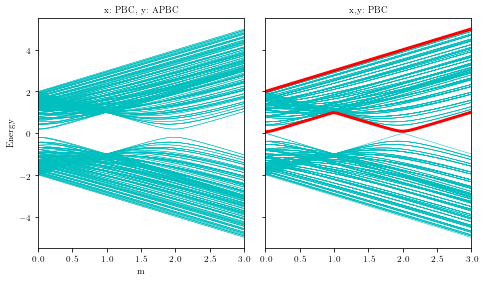

In [96]:
fig,ax=plt.subplots(1,2,sharey=True,sharex=True,tight_layout=True)
ax[0].plot(m_list,eigval_apbc_list,'c',lw=0.5)
ax[1].plot(m_list,eigval_pbc_list,'c',lw=0.5)
ax[0].set_xlabel(r'm')
ax[0].set_ylabel(r'Energy')
ax[1].plot(m_list,en_min,'r',lw=3)
ax[1].plot(m_list,en_max,'r',lw=3)
ax[0].margins(x=0)
ax[0].set_title('x: PBC, y: APBC')
ax[1].set_title('x,y: PBC')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/bs.pdf',bbox_inches='tight')

# No measurement

## finite

In [83]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,40))
# m_list=np.linspace(1,3,20)
LN_no_list=[]
MI_no_list=[]
for m in m_list:
    params=Params(m=m,Lx=128,Ly=4)
    MI_no_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN_no_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


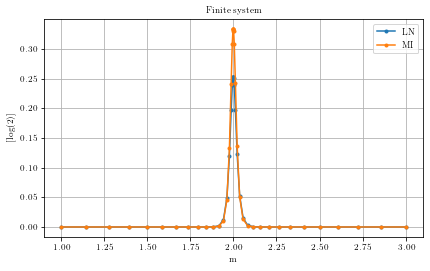

In [89]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list/np.log(2),'.-',label='LN')
ax.plot(m_list,MI_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.grid('on')
ax.set_ylabel('[log(2)]')
ax.set_title('Finite system')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_CI_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Inf

In [77]:
# m_list=np.linspace(1,3,20)
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,20))
LN_no_inf_list=[]
MI_no_inf_list=[]
for m in m_list:
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=32,dymax=8)
    MI_no_inf_list.append(params.mutual_information_m([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))
    LN_no_inf_list.append(params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))

Text(0.5, 1.0, 'Infinite system')

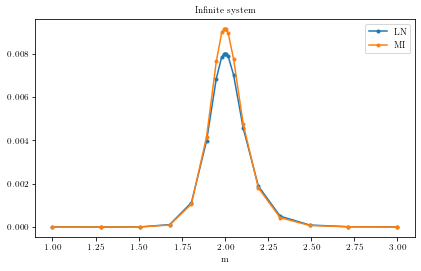

In [78]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_inf_list,'.-',label='LN')
ax.plot(m_list,MI_no_inf_list,'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.set_title('Infinite system')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_CI_no_inf_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')


# Measure to 0

In [51]:
m_list=np.linspace(1,3,20)
es=1
LN_empty_list=np.zeros((len(m_list),es))
MI_empty_list=np.zeros((len(m_list),es))
Lx,Ly=16,4
for m_i,m in enumerate(m_list):
    # st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0)
        MI_empty_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_empty_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_empty_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


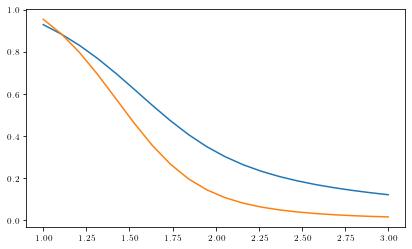

In [52]:
plt.plot(m_list,LN_empty_list)
plt.plot(m_list,MI_empty_list)

# Measure to 0.5

In [16]:
m_list=np.linspace(1,3,20)
es=50
LN_half_list=np.zeros((len(m_list),es))
MI_half_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=16,Ly=8)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0.5)
        # MI_half_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_half_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    #  # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])],0.5).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_half_list[m_i,:]=async_result 

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:0.3


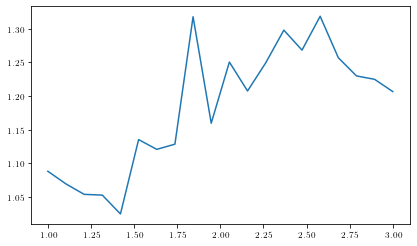

In [14]:
plt.plot(m_list,LN_half_list.mean(axis=1))
# plt.plot(m_list,LN_empty_list)

# Measure to 1

In [182]:
m_list=np.linspace(1,3,20)
es=1
LN_occ_list=np.zeros((len(m_list),es))
MI_occ_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],1)
        # MI_occ_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_occ_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_occ_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


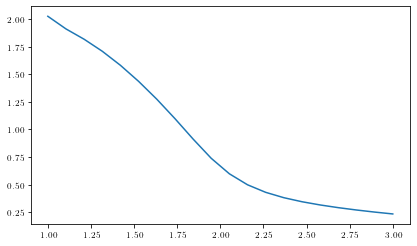

In [184]:
plt.plot(m_list,LN_occ_list)
# plt.plot(m_list,LN_empty_list)

# Born measurement

## onsite

In [100]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_list[m_i,index],LN_Born_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:302.3
1:319.2
2:341.7
3:307.5
4:303.9
5:322.2
6:333.0
7:318.6
8:309.1
9:314.1


In [220]:
es,Lx,Ly=500,16,32
with open('/mnt/d/KITP/Rp_SPT/8/MI_LN_CI_Born_En{:d}_Lx{:d}_Ly{:d}.pickle'.format(es,Lx,Ly),'rb') as f:
    [m_list,MI_Born_list,LN_Born_list,MI_no_list,LN_no_list]=pickle.load(f)

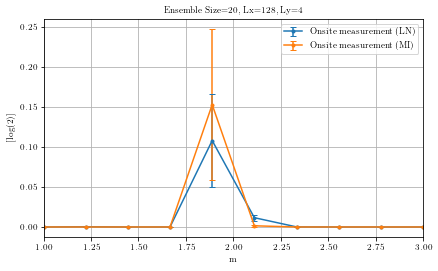

In [101]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'[log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_onsite_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link

In [112]:
params=Params(m=1,Lx=64,Ly=8,bcx=-1,bcy=1)

In [72]:
params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],type='link')

In [73]:
params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])/np.log(2)

0.26642745140122653

In [5]:
m_list=np.linspace(1,3,10)
es=50
LN_Born_link_list=np.zeros((len(m_list),es))
MI_Born_link_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link')
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_link_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_link_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_list[m_i,index],LN_Born_link_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:330.4
1:360.5
2:363.9
3:368.3
4:380.2
5:436.0
6:439.4
7:440.5
8:953.7
9:1153.6
10:756.3
11:375.3
12:363.5
13:365.9
14:353.5
15:351.9
16:345.9
17:356.5
18:370.9
19:394.2
20:378.0
21:388.7
22:388.1
23:404.4
24:406.7


In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_list.mean(axis=1)/np.log(2),LN_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_list.mean(axis=1)/np.log(2),MI_Born_link_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link force to o+

In [77]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_list=[]
MI_Born_link_op_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[1,0,0,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_list.append(results[0])
    LN_Born_link_op_list.append(results[1])


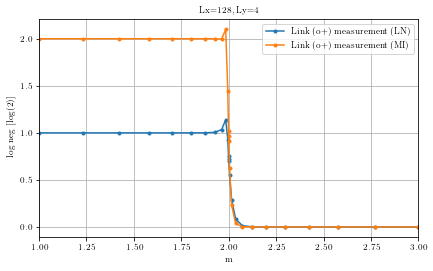

In [93]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Link force to o-

In [79]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_om_list=[]
MI_Born_link_om_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[0,1,0,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_om_list.append(results[0])
    LN_Born_link_om_list.append(results[1])


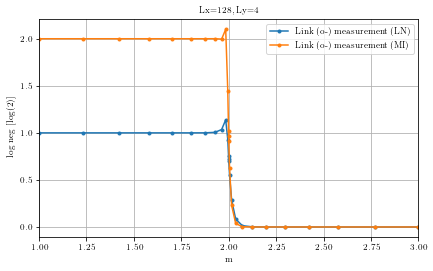

In [94]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_om_list/np.log(2),'.-',label='Link (o-) measurement (LN)')
ax.plot(m_list,MI_Born_link_om_list/np.log(2),'.-',label='Link (o-) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_om_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## Link force to e+

In [85]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_ep_list=[]
MI_Born_link_ep_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',prob=[0,0,1,0])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_ep_list.append(results[0])
    LN_Born_link_ep_list.append(results[1])


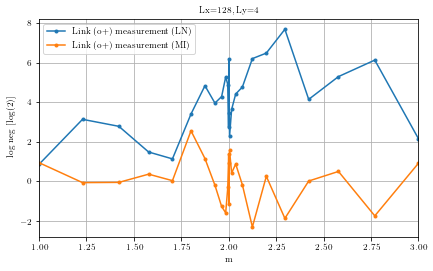

In [86]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_ep_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_ep_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_ep_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link, Born but with only {o+,o-}

In [100]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool2_list=np.zeros((len(m_list),es))
MI_Born_link_pool2_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',pool=2)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool2_list[m_i,index],LN_Born_link_pool2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:133.4
1:131.7
2:131.0
3:131.3
4:132.1
5:135.5
6:165.4
7:152.6
8:132.0
9:134.2


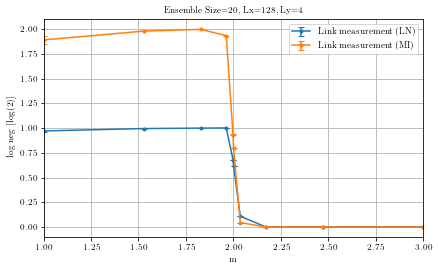

In [101]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool2_list.mean(axis=1)/np.log(2),LN_Born_link_pool2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool2_list.mean(axis=1)/np.log(2),MI_Born_link_pool2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Link, Born but with only {e+,e-}

In [126]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_poolm2_list=np.zeros((len(m_list),es))
MI_Born_link_poolm2_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link',pool=-2)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_poolm2_list[m_i,index],LN_Born_link_poolm2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:125.0
1:123.9
2:130.1
3:138.7
4:140.2
5:141.3
6:141.5
7:142.3
8:137.0
9:135.9


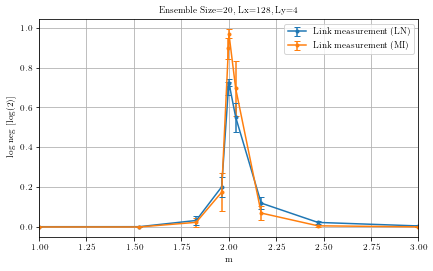

In [127]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_poolm2_list.mean(axis=1)/np.log(2),LN_Born_link_poolm2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_poolm2_list.mean(axis=1)/np.log(2),MI_Born_link_poolm2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_poolm2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [ ]:
## see if there is a connected path ,and that fine

## all o+ but the last is e+

In [31]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_list=[]
MI_Born_link_op_ep_list=[]
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0[:-1],type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_0[-1:],type='link',prob=[0,0,1,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))
# async_result=(map(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_ep_list.append(results[0])
    LN_Born_link_op_ep_list.append(results[1])


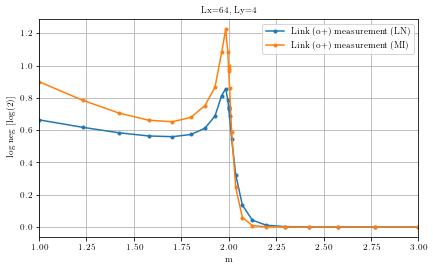

In [32]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## all o+ but the middle is e+

In [128]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_middle_list=[]
MI_Born_link_op_ep_middle_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0[:len(proj_range_0)//2],type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_0[len(proj_range_0)//2:len(proj_range_0)//2+1],type='link',prob=[0,0,1,0],linear=True)
    params.measure_all_Born(proj_range_0[len(proj_range_0)//2+1:],type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
# async_result=(rc[:].map_sync(run,inputs))
async_result=(map(run,inputs))


for index,results in enumerate(async_result):
    MI_Born_link_op_ep_middle_list.append(results[0])
    LN_Born_link_op_ep_middle_list.append(results[1])



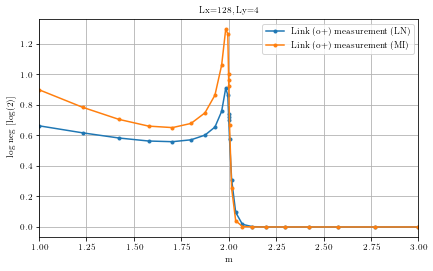

In [129]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_middle_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_middle_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_middle_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## one chain of Ly is o+, others are e+

## one ring is o+, in between Born

In [104]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
m_list=np.linspace(1,3,20)
LN_Born_link_op_ep_ring_middle_list=[]
MI_Born_link_op_ep_ring_middle_list=[]
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',prob=[1,0,0,0],linear=True)
    params.measure_all_Born(proj_range_1,type='link',prob=[0,0,1,0],linear=True)
    params.measure_all_Born(proj_range_2,type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
# async_result=(rc[:].map_sync(run,inputs))
async_result=(map(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_ep_ring_middle_list.append(results[0])
    LN_Born_link_op_ep_ring_middle_list.append(results[1])


In [71]:
run((1,128,4))

(1.330400147538711, 0.7050467066112442)

In [83]:
LN_Born_link_op_ep_ring_middle_list

[0.7050467066112442, 0.5541622680318721]

In [84]:
MI_Born_link_op_ep_ring_middle_list

[1.330400147538711, 0.8815233724717966]

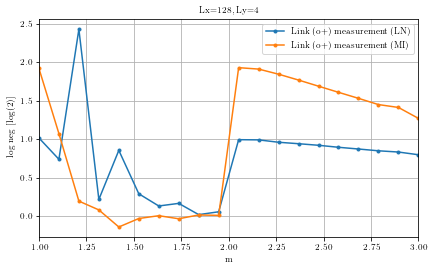

In [109]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_ring_middle_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_ring_middle_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_ring_middle_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## one ring is {o+,o-}, in between {e+,e-}

In [ ]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool22_list=np.zeros((len(m_list),es))
MI_Born_link_pool22_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',pool=2,linear=True)
    params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
    params.measure_all_Born(proj_range_2,type='link',pool=2,linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool22_list[m_i,index],LN_Born_link_pool22_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


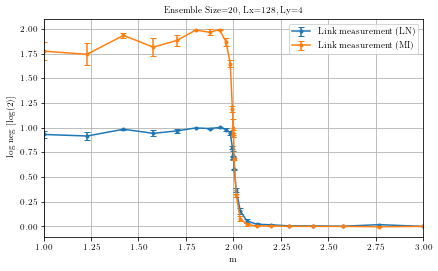

In [125]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool22_list.mean(axis=1)/np.log(2),LN_Born_link_pool22_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool22_list.mean(axis=1)/np.log(2),MI_Born_link_pool22_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool22_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## one ring is {o+,o-}, in between no measurement

In [130]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
es=20
LN_Born_link_pool2no2_list=np.zeros((len(m_list),es))
MI_Born_link_pool2no2_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',pool=2,linear=True)
    # params.measure_all_Born(proj_range_1,type='link',pool=-2,linear=True)
    params.measure_all_Born(proj_range_2,type='link',pool=2,linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN
for m_i,m in enumerate(m_list):
    st=time.time()

    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_pool2no2_list[m_i,index],LN_Born_link_pool2no2_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


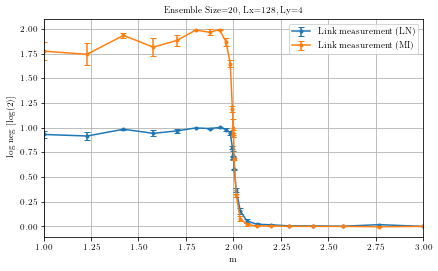

In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_link_pool2no2_list.mean(axis=1)/np.log(2),LN_Born_link_pool2no2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_pool2no2_list.mean(axis=1)/np.log(2),MI_Born_link_pool2no2_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_pool2no2_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## one ring is o+, in between no measure

In [110]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,25))
# m_list=np.linspace(1,3,10)
LN_Born_link_op_ep_ring_middle_no_list=[]
MI_Born_link_op_ep_ring_middle_no_list=[]
Lx,Ly=64,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    proj_range_0=params.linearize_index([np.arange(params.Lx//4,3*params.Lx//8),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_1=params.linearize_index([np.arange(3*params.Lx//8,3*params.Lx//8+1),np.arange(0,params.Ly)],4,proj=True,k=4)
    proj_range_2=params.linearize_index([np.arange(3*params.Lx//8+1,params.Lx//2),np.arange(0,params.Ly)],4,proj=True,k=4)
    params.measure_all_Born(proj_range_0,type='link',prob=[1,0,0,0],linear=True)
    # params.measure_all_Born(proj_range_1,type='link',prob=[0,0,1,0],linear=True)
    params.measure_all_Born(proj_range_2,type='link',prob=[1,0,0,0],linear=True)
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

    
inputs=[(m,Lx,Ly) for m in m_list]
async_result=(rc[:].map_sync(run,inputs))

for index,results in enumerate(async_result):
    MI_Born_link_op_ep_ring_middle_no_list.append(results[0])
    LN_Born_link_op_ep_ring_middle_no_list.append(results[1])


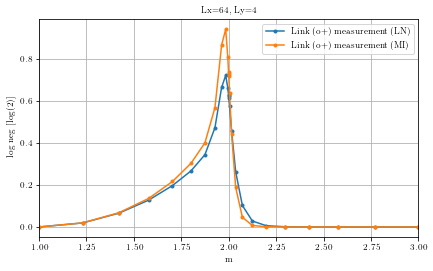

In [111]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.plot(m_list,LN_Born_link_op_ep_ring_middle_no_list/np.log(2),'.-',label='Link (o+) measurement (LN)')
ax.plot(m_list,MI_Born_link_op_ep_ring_middle_no_list/np.log(2),'.-',label='Link (o+) measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Lx={:d}, Ly={:d}'.format(Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_op_ep_ring_middle_no_Lx{:d}_Ly{:d}.pdf'.format(Lx,Ly),bbox_inches='tight')

## ignore symmetry, use four bell states

## Inf onsite

In [102]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_inf_list=np.zeros((len(m_list),es))
MI_Born_inf_list=np.zeros((len(m_list),es))
Lx,Ly=128,4
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)])
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_inf_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_inf_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_inf_list[m_i,index],LN_Born_inf_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:268.7
1:268.1
2:277.8


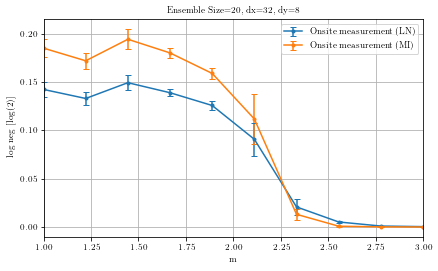

In [ ]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_inf_list,'.-',label='No measurement (LN)')
# ax.plot(m_list,MI_no_inf_list,'.-',label='No measurement (MI)')

ax.errorbar(m_list,LN_Born_inf_list.mean(axis=1)/np.log(2),LN_Born_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_inf_list.mean(axis=1)/np.log(2),MI_Born_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, dx={:d}, dy={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

## Inf link

In [97]:
m_list=np.linspace(1,3,10)
es=20
LN_Born_link_inf_list=np.zeros((len(m_list),es))
MI_Born_link_inf_list=np.zeros((len(m_list),es))
Lx,Ly=64,8
def run(p):
    m,Lx,Ly=p
    params=Params(m=m,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf,bcx=-1,bcy=1)
    params.measure_all_Born([np.arange(Lx//4,Lx//2),np.arange(Ly)],type='link')
    LN=params.log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    MI=params.mutual_information_m([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)])
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_link_inf_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_link_inf_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)

    for index,results in enumerate(async_result):
        MI_Born_link_inf_list[m_i,index],LN_Born_link_inf_list[m_i,index]=results

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:173.9
1:161.7
2:163.1
3:156.2
4:159.5
5:165.9
6:161.2
7:154.0
8:158.0
9:158.9


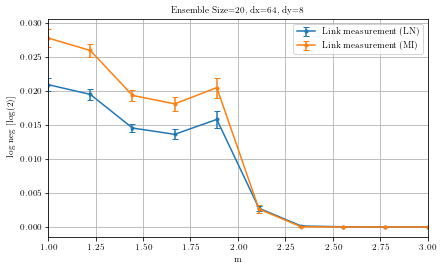

In [98]:
fig,ax=plt.subplots()
ax.errorbar(m_list,LN_Born_link_inf_list.mean(axis=1)/np.log(2),LN_Born_link_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (LN)')
ax.errorbar(m_list,MI_Born_link_inf_list.mean(axis=1)/np.log(2),MI_Born_link_inf_list.std(axis=1)/np.sqrt(es-1),capsize=3,fmt='.-',label='Link measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, dx={:d}, dy={:d}'.format(es,Lx,Ly))
fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_link_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')


# Scaling at m=2

## no measurement

In [1]:
import matplotlib.patches as mpatches
def place_region(x,y,fig,ax,color='ybyk'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    [fig.artists.append(arc) for arc in arc]
    ax.text(x+25,y+25,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+25,y-25,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x-25,y-25,r'$B$',transform=None,ha='center',va='center')
    ax.text(x-25,y+25,r'$B^\prime$',transform=None,ha='center',va='center')

In [ ]:
eta_no_list=[]
MI_no_list=[]
LN_no_list=[]
x_list=[]
L=32
params=Params(m=2,Lx=L,Ly=16)
for ii in range(500):
    print(ii)
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while x in x_list:
        x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    x_list.append(x)
    eta=cross_ratio(x,L)
    eta_no_list.append(eta)
    subregionA=[np.arange(x[0],x[1]),np.arange(params.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params.Ly)]
    MI=params.mutual_information_m(subregionA,subregionB)    
    MI_no_list.append(MI)
    LN=params.log_neg(subregionA,subregionB)
    LN_no_list.append(LN)
eta_no_list=np.array(eta_no_list)
MI_no_list=np.array(MI_no_list)
LN_no_list=np.array(LN_no_list)

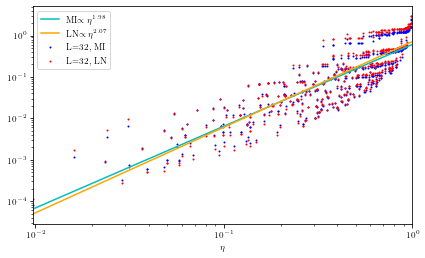

In [113]:
fig,ax=plt.subplots()
ax.scatter(eta_no_list,MI_no_list,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_no_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_no_list>1e-10)&((eta_no_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_no_list[mask_MI]),np.log(MI_no_list[mask_MI]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ykyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_no.pdf')

## Born measurement

In [ ]:
eta_Born_onsite_Ap_list=[]
MI_Born_onsite_Ap_list=[]
LN_Born_onsite_Ap_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=16
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_Ap_list.append(eta)
    MI_Born_onsite_Ap_list.append(MI_ensemble_list)
    LN_Born_onsite_Ap_list.append(LN_ensemble_list)
eta_Born_onsite_Ap_list=np.array(eta_Born_onsite_Ap_list)
MI_Born_onsite_Ap_list=np.array(MI_Born_onsite_Ap_list)
LN_Born_onsite_Ap_list=np.array(LN_Born_onsite_Ap_list)

In [97]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_Ap.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

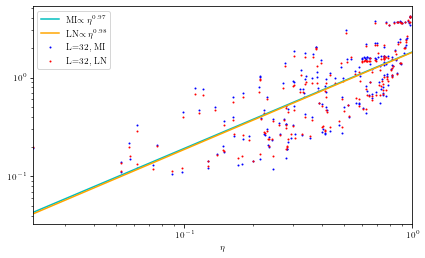

In [100]:
MI_Born_onsite_Ap_list_mean=MI_Born_onsite_Ap_list.mean(axis=1)
LN_Born_onsite_Ap_list_mean=LN_Born_onsite_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_Ap_list,LN_Born_onsite_Ap_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_MI]),np.log(MI_Born_onsite_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_LN]),np.log(LN_Born_onsite_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_Ap.pdf')


In [10]:
eta_Born_onsite_ApBp_list=[]
MI_Born_onsite_ApBp_list=[]
LN_Born_onsite_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=32
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    subregionBp=[np.arange(x[3],L),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_ApBp_list.append(eta)
    MI_Born_onsite_ApBp_list.append(MI_ensemble_list)
    LN_Born_onsite_ApBp_list.append(LN_ensemble_list)
eta_Born_onsite_ApBp_list=np.array(eta_Born_onsite_ApBp_list)
MI_Born_onsite_ApBp_list=np.array(MI_Born_onsite_ApBp_list)
LN_Born_onsite_ApBp_list=np.array(LN_Born_onsite_ApBp_list)

In [114]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_ApBp.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

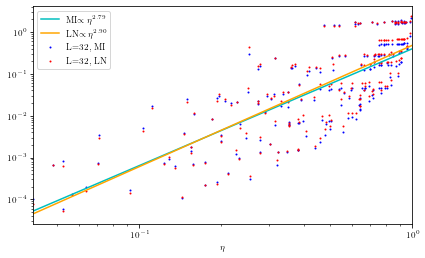

In [116]:
MI_Born_onsite_ApBp_list_mean=MI_Born_onsite_ApBp_list.mean(axis=1)
LN_Born_onsite_ApBp_list_mean=LN_Born_onsite_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_ApBp_list,MI_Born_onsite_ApBp_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_ApBp_list,LN_Born_onsite_ApBp_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_MI]),np.log(MI_Born_onsite_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_LN]),np.log(LN_Born_onsite_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_ApBp.pdf')


# Check area law of EE

In [72]:
EE_list={}

In [74]:
l_EE_list=np.arange(2,32)
for Ly in (8,12,16):
    params=Params(m=1,Lx=32,Ly=Ly)
    EE_list[Ly]=[(params.von_Neumann_entropy_f([np.arange(l),np.arange(params.Ly)])) for l in l_EE_list]


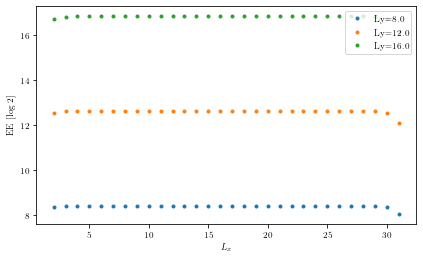

In [75]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

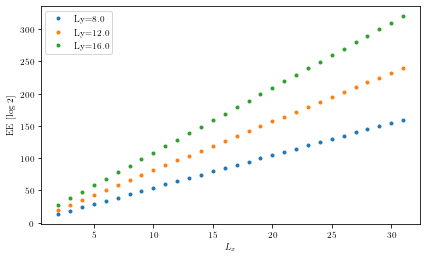

In [ ]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

# LN scaling behavior

In [133]:
LN_scaling_list={}

## fix dist, |A|_x, increase |A|_y

In [1]:
LN_Ay={}

In [19]:
Ly_list=np.arange(1,16)
Lx=32
LN_Ay=[Params(m=1,Lx=Lx,Ly=Ly).log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)]) for Ly in Ly_list]


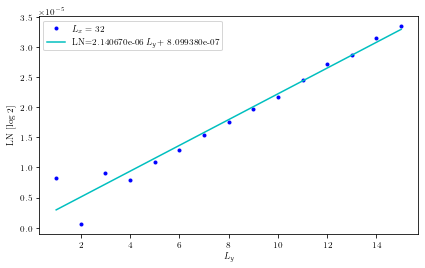

In [20]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_Ay/np.log(2),'.',label=r'$L_x={:d}$'.format(Lx),color='b')
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Ly_list,LN_Ay/np.log(2))
xfit=Ly_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_y$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

# fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_Ay.pdf',bbox_inches='tight')

## fix dist, |A|_y, increase |A|_x

In [32]:
Lx_list=np.arange(2,20)
Ly=32
dist=8
LN_Ax=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for Lx in Lx_list]


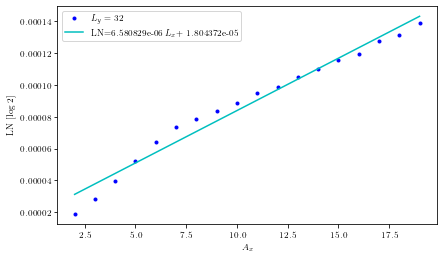

In [33]:
fig,ax=plt.subplots()
ax.plot(Lx_list,LN_Ax/np.log(2),'.',label=r'$L_y={:d}$'.format(Ly),color='b')
ax.set_xlabel(r'$A_x$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Lx_list,LN_Ax/np.log(2))
xfit=Lx_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_x$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_Ax.pdf',bbox_inches='tight')

## fix |A|_x, |A|_y, increase dist 

In [4]:
dist_list=np.arange(2,16)
Lx=8
Ly=128
dist=8
# LN_dist=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for dist in dist_list]
LN_dist=[]
for dist in dist_list:
    st=time.time()
    LN_dist.append(Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]))
    print("{:d}:{:.2f}".format(dist,time.time()-st))
    with open('dist.pickle','wb') as f:
        pickle.dump([dist_list,LN_dist],f)

2:716.00
3:876.40
4:547.58
5:433.58
6:479.31
7:546.73
8:497.55
9:521.40
10:559.04
11:605.54
12:666.71
13:718.21
14:903.57
15:1152.39


In [37]:
dist_list=np.array(dist_list)
LN_dist=np.array(LN_dist)
fig,ax=plt.subplots(3,1,figsize=(6.8,8),tight_layout=True)
ax[0].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[0].set_title('Linear(x)-Linear(y)')
ax[1].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[1].set_yscale('log')
ax[1].set_title('Linear(x)-Log(y)')

ax[2].plot((dist_list),(LN_dist/np.log(2)),'.')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Log(x)-Log(y)')

ax[-1].set_xlabel(r'$A^\prime_x$')
[ax.set_ylabel(r'LN [log 2]') for ax in ax]

mask=dist_list<10
lr=scipy.stats.linregress((dist_list[mask]),np.log(LN_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[1].plot(xfit,np.exp(lr.slope*xfit+lr.intercept),'c',label=r'LN=exp({:.4f}~d+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))
ax[1].legend()
mask=dist_list<10
lr=scipy.stats.linregress(np.log(dist_list[mask]),np.log(LN_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[2].plot(xfit,np.exp(lr.slope*np.log(xfit)+lr.intercept),'c',label=r'LN=exp({:.4f}~log(d)+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))# ax[0].legend()
ax[2].legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_dist.pdf',bbox_inches='tight')

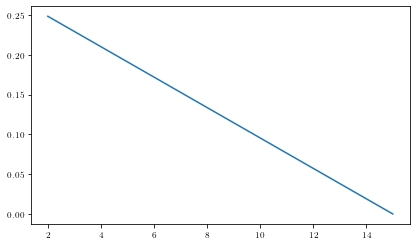

In [13]:
plt.plot(xfit,np.exp(lr.slope*xfit+lr.intercept))

In [241]:
lr.rvalue

-0.9887073032162419

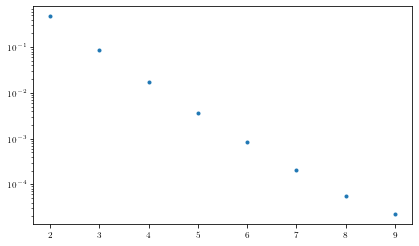

In [233]:
fig,ax=plt.subplots()
ax.plot(dist_list,LN_dist,'.')
# ax.set_xscale('log')
ax.set_yscale('log')

In [55]:
Ly_list=np.arange(2,16)
Lx_list=np.arange(2,8)
LN_scaling_list=np.zeros((Lx_list.shape[0],Ly_list.shape[0]))
for Ly_i,Ly in enumerate(Ly_list):
    for Lx_i,Lx in enumerate(Lx_list):
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Lx_i,Ly_i]=params.log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+2*Lx,np.arange(Ly)])


In [56]:
Lx_map,Ly_map=np.meshgrid(Lx_list,Ly_list)

In [ ]:
plt.plot()

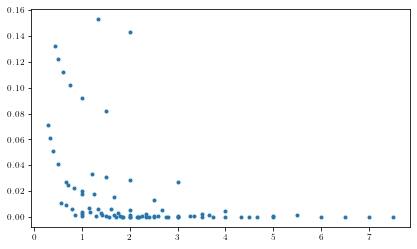

In [57]:
plt.plot((Ly_map/Lx_map).flatten(),LN_scaling_list.flatten(),'.')

Text(0, 0.5, 'log neg')

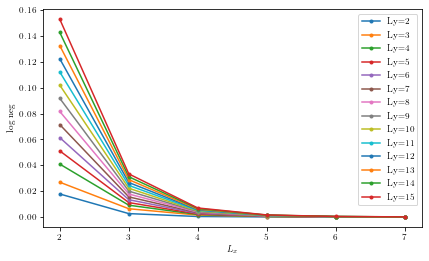

In [121]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

Text(0, 0.5, 'log neg')

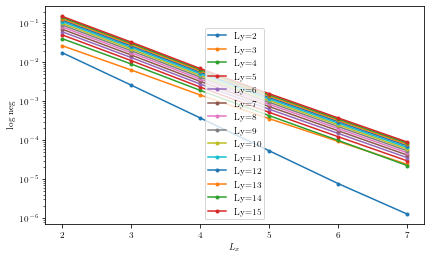

In [122]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

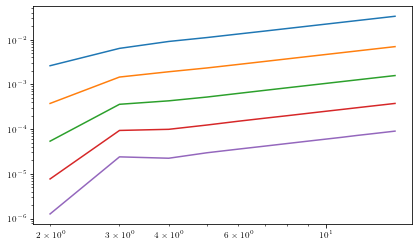

In [71]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_scaling_list[1,:])
ax.plot(Ly_list,LN_scaling_list[2,:])
ax.plot(Ly_list,LN_scaling_list[3,:])
ax.plot(Ly_list,LN_scaling_list[4,:])
ax.plot(Ly_list,LN_scaling_list[5,:])
ax.set_yscale('log')
ax.set_xscale('log')

In [69]:
l_LN_list=np.arange(2,8)
for Ly in (8,12,16):
    LN_scaling_list[Ly]=[]
    for Lx in l_LN_list:
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Ly].append(params.log_neg([np.arange(Lx),np.arange(params.Ly)],[np.arange(Lx)+2*Lx,np.arange(params.Ly)]))

Text(0, 0.5, 'Log neg [log 2]')

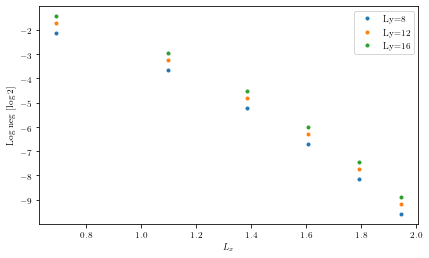

In [75]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(np.log(l_LN_list),np.log(v/np.log(2)),'.',label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

In [80]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

Text(0, 0.5, 'Log neg [log 2]')

Text(0, 0.5, 'Log neg [log 2]')

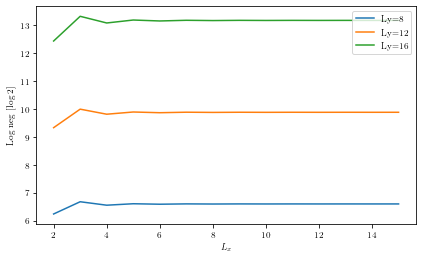

In [95]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

## Infinite 

## fix dist, |A|_x, increase |A|_y

In [149]:
LN_Ay={}

In [66]:
Ly_list=np.arange(2,32)
Lx=8
LN_inf_Ay=[Params(m=1,dxmax=Lx,dymax=Ly,Lx=np.inf,Ly=np.inf).log_neg([np.arange(Lx//4),np.arange(Ly)],[np.arange(Lx//4)+Lx//2,np.arange(Ly)]) for Ly in Ly_list]


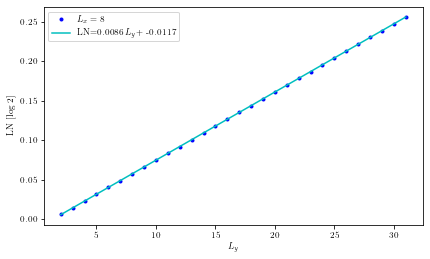

In [68]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_inf_Ay/np.log(2),'.',label=r'$L_x={:d}$'.format(Lx),color='b')
ax.set_xlabel(r'$L_y$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Ly_list,LN_inf_Ay/np.log(2))
xfit=Ly_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:.4f}~$L_y$+ {:.4f}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_inf_Ay.pdf',bbox_inches='tight')

## fix dist, |A|_y, increase |A|_x

In [69]:
Lx_list=np.arange(2,20)
Ly=32
dist=8
LN_inf_Ax=[Params(m=1,dxmax=2*Lx+2*dist,dymax=Ly,Lx=np.inf,Ly=np.inf).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for Lx in Lx_list]


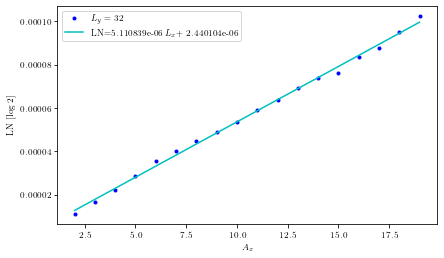

In [70]:
fig,ax=plt.subplots()
ax.plot(Lx_list,LN_inf_Ax/np.log(2),'.',label=r'$L_y={:d}$'.format(Ly),color='b')
ax.set_xlabel(r'$A_x$')
ax.set_ylabel(r'LN [log 2]')
lr=scipy.stats.linregress(Lx_list,LN_inf_Ax/np.log(2))
xfit=Lx_list[[0,-1]]
ax.plot(xfit,lr.slope*xfit+lr.intercept,'c',label=r'LN={:e}~$L_x$+ {:e}'.format(lr.slope,lr.intercept))

ax.legend()

fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_inf_Ax.pdf',bbox_inches='tight')

## fix |A|_x, |A|_y, increase dist 

In [73]:
dist_list=np.arange(2,16)
Lx=8
Ly=32
dist=8
# LN_inf_dist=[Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]) for dist in dist_list]
LN_inf_dist=[]
for dist in dist_list:
    st=time.time()
    LN_inf_dist.append(Params(m=1,Lx=2*Lx+2*dist,Ly=Ly).log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+dist+Lx,np.arange(Ly)]))
    print("{:d}:{:.2f}".format(dist,time.time()-st))
    # with open('dist.pickle','wb') as f:
    #     pickle.dump([dist_list,LN_inf_dist],f)

2:5.76
3:6.60
4:7.52
5:7.60
6:9.84
7:10.71
8:11.73
9:11.80
10:12.39
11:13.46
12:14.94
13:15.45
14:17.52
15:18.30


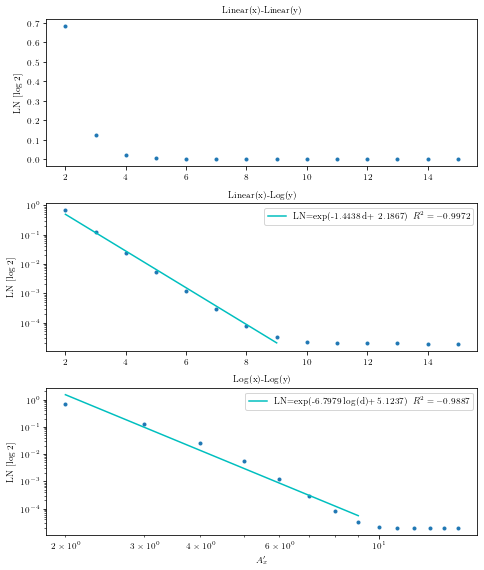

In [74]:
dist_list=np.array(dist_list)
LN_inf_dist=np.array(LN_inf_dist)
fig,ax=plt.subplots(3,1,figsize=(6.8,8),tight_layout=True)
ax[0].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[0].set_title('Linear(x)-Linear(y)')
ax[1].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[1].set_yscale('log')
ax[1].set_title('Linear(x)-Log(y)')

ax[2].plot((dist_list),(LN_inf_dist/np.log(2)),'.')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Log(x)-Log(y)')

ax[-1].set_xlabel(r'$A^\prime_x$')
[ax.set_ylabel(r'LN [log 2]') for ax in ax]

mask=dist_list<10
lr=scipy.stats.linregress((dist_list[mask]),np.log(LN_inf_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[1].plot(xfit,np.exp(lr.slope*xfit+lr.intercept),'c',label=r'LN=exp({:.4f}~d+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))
ax[1].legend()
mask=dist_list<10
lr=scipy.stats.linregress(np.log(dist_list[mask]),np.log(LN_inf_dist[mask]/np.log(2)))
xfit=dist_list[mask]
ax[2].plot(xfit,np.exp(lr.slope*np.log(xfit)+lr.intercept),'c',label=r'LN=exp({:.4f}~log(d)+ {:.4f}) $~R^2={:.4f}$'.format(lr.slope,lr.intercept,lr.rvalue))# ax[0].legend()
ax[2].legend()

fig.savefig('//mnt/d/kitp/Rp_SPT/8/LN_inf_dist.pdf',bbox_inches='tight')

# Measurement based on geometry


## genus (0,0) --a

In [60]:
params_g00_a=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [53]:
proj_total_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax),np.arange(params_g00_a.dymax)],4,proj=True)
ax,ay=4,4
proj_A_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax//4-ax//2,params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4,proj=True)
proj_B_g00_a=params_g00_a.linearize_index([np.arange(3*params_g00_a.dxmax//4-ax//2,3*params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4,proj=True)
proj_range_g00_a=np.setdiff1d(proj_total_g00_a,np.union1d(proj_A_g00_a,proj_B_g00_a))
sub_A_g00_a=params_g00_a.linearize_index([np.arange(params_g00_a.dxmax//4-ax//2,params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4)
sub_B_g00_a=params_g00_a.linearize_index([np.arange(3*params_g00_a.dxmax//4-ax//2,3*params_g00_a.dxmax//4+ax//2),np.arange(params_g00_a.dymax//2-ay//2,params_g00_a.dymax//2+ay//2)],4)

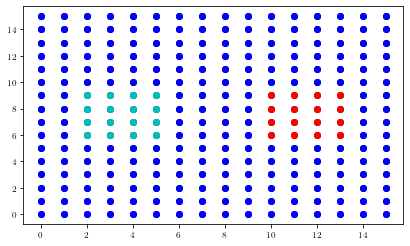

In [54]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_a.square_index(proj_total_g00_a),color='k')
ax.scatter(*params_g00_a.square_index(sub_A_g00_a),color='c')
ax.scatter(*params_g00_a.square_index(sub_B_g00_a),color='r')
ax.scatter(*params_g00_a.square_index(proj_range_g00_a),color='b')

In [65]:
m_list_g00_a=np.linspace(1,3,20)
es_g00_a=50
LN_Born_inf_list_g00_a=np.zeros((len(m_list_g00_a),es_g00_a))
MI_Born_inf_list_g00_a=np.zeros((len(m_list_g00_a),es_g00_a))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_a=[]
for m_i,m in enumerate(m_list_g00_a):
    inputs=[(proj_range_g00_a,sub_A_g00_a,sub_B_g00_a,m) for _ in range(es_g00_a)]
    async_result_g00_a.append(rc[:].map_async(run,inputs))


In [156]:
LN_Born_inf_list_g00_a=[]
for m_i,m in enumerate(m_list_g00_a):
    st=time.time()
    LN_Born_inf_list_g00_a.append(async_result_g00_a[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_a=np.array(LN_Born_inf_list_g00_a)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


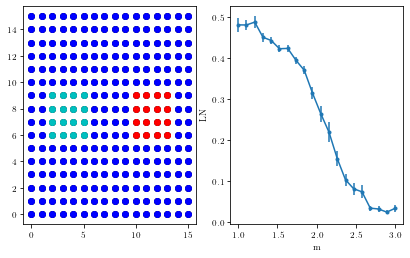

In [157]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_a.square_index(proj_total_g00_a),color='k')
ax[0].scatter(*params_g00_a.square_index(sub_A_g00_a),color='c')
ax[0].scatter(*params_g00_a.square_index(sub_B_g00_a),color='r')
ax[0].scatter(*params_g00_a.square_index(proj_range_g00_a),color='b')
ax[1].errorbar(m_list_g00_a,LN_Born_inf_list_g00_a.mean(axis=1),LN_Born_inf_list_g00_a.std(axis=1)/np.sqrt(es_g00_a-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g00_a.pdf')

## geneus (0,1) --a

In [69]:
params_g01_a=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [70]:
proj_total_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax),np.arange(params_g01_a.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax//4-ax//2,params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4,proj=True)
sub_A_g01_a=params_g01_a.linearize_index([np.arange(params_g01_a.dxmax//4-ax//2,params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4)
proj_B_1_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax//2,3*params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4,proj=True)
proj_B_2_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax2//2,3*params_g01_a.dxmax//4+ax2//2),np.arange(params_g01_a.dymax//2-ay2//2,params_g01_a.dymax//2+ay2//2)],4,proj=True)
proj_B_g01_a=np.setdiff1d(proj_B_2_g01_a,proj_B_1_g01_a)
proj_range_g01_a=np.setdiff1d(proj_total_g01_a,np.union1d(proj_A_g01_a,proj_B_2_g01_a))

sub_B_1_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax//2,3*params_g01_a.dxmax//4+ax//2),np.arange(params_g01_a.dymax//2-ay//2,params_g01_a.dymax//2+ay//2)],4)
sub_B_2_g01_a=params_g01_a.linearize_index([np.arange(3*params_g01_a.dxmax//4-ax2//2,3*params_g01_a.dxmax//4+ax2//2),np.arange(params_g01_a.dymax//2-ay2//2,params_g01_a.dymax//2+ay2//2)],4)
sub_B_g01_a=np.setdiff1d(sub_B_2_g01_a,sub_B_1_g01_a)


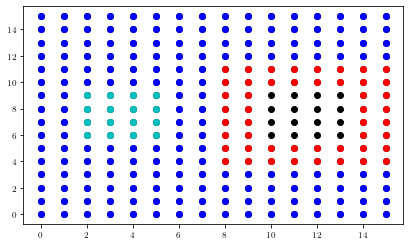

In [71]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_a.square_index(proj_total_g01_a),color='k')
ax.scatter(*params_g01_a.square_index(sub_A_g01_a),color='c')
ax.scatter(*params_g01_a.square_index(sub_B_g01_a),color='r')
ax.scatter(*params_g01_a.square_index(proj_range_g01_a),color='b')

In [72]:
m_list_g01_a=np.linspace(1,3,20)
es_g01_a=50
LN_Born_inf_list_g01_a=np.zeros((len(m_list_g01_a),es_g01_a))
MI_Born_inf_list_g01_a=np.zeros((len(m_list_g01_a),es_g01_a))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_a=[]
for m_i,m in enumerate(m_list_g01_a):
    inputs=[(proj_range_g01_a,sub_A_g01_a,sub_B_g01_a,m) for _ in range(es_g01_a)]
    async_result_g01_a.append(rc[:].map_async(run,inputs))


In [158]:
LN_Born_inf_list_g01_a=[]
for m_i,m in enumerate(m_list_g01_a):
    st=time.time()
    LN_Born_inf_list_g01_a.append(async_result_g01_a[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_a=np.array(LN_Born_inf_list_g01_a)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


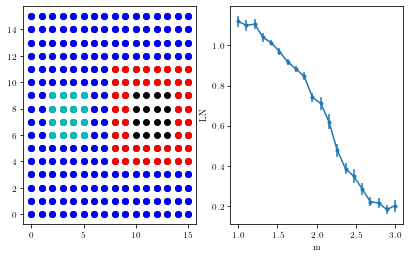

In [159]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_a.square_index(proj_total_g01_a),color='k')
ax[0].scatter(*params_g01_a.square_index(sub_A_g01_a),color='c')
ax[0].scatter(*params_g01_a.square_index(sub_B_g01_a),color='r')
ax[0].scatter(*params_g01_a.square_index(proj_range_g01_a),color='b')
ax[1].errorbar(m_list_g01_a,LN_Born_inf_list_g01_a.mean(axis=1),LN_Born_inf_list_g01_a.std(axis=1)/np.sqrt(es_g01_a-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g01_a.pdf')

## geneus (0,1) --b

In [73]:
params_g01_b=Params(m=1,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)

In [152]:
proj_total_g01_b=params_g01_b.linearize_index([np.arange(params_g01_b.dxmax),np.arange(params_g01_b.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
sub_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4)

proj_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4,proj=True)
proj_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4,proj=True)
proj_range_g01_b=np.setdiff1d(proj_B_1_g01_b,proj_A_g01_b)

sub_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4)
sub_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4)
sub_B_g01_b=np.setdiff1d(sub_B_2_g01_b,sub_B_1_g01_b)


In [153]:
proj_total_g01_b=params_g01_b.linearize_index([np.arange(params_g01_b.dxmax),np.arange(params_g01_b.dymax)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
sub_A_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4)

proj_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax//2,2*params_g01_b.dxmax//4+ax//2),np.arange(params_g01_b.dymax//2-ay//2,params_g01_b.dymax//2+ay//2)],4,proj=True)
proj_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4,proj=True)
proj_range_g01_b=np.setdiff1d(proj_B_2_g01_b,proj_B_1_g01_b)

sub_B_1_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax2//2,2*params_g01_b.dxmax//4+ax2//2),np.arange(params_g01_b.dymax//2-ay2//2,params_g01_b.dymax//2+ay2//2)],4)
sub_B_2_g01_b=params_g01_b.linearize_index([np.arange(2*params_g01_b.dxmax//4-ax3//2,2*params_g01_b.dxmax//4+ax3//2),np.arange(params_g01_b.dymax//2-ay3//2,params_g01_b.dymax//2+ay3//2)],4)
sub_B_g01_b=np.setdiff1d(sub_B_2_g01_b,sub_B_1_g01_b)


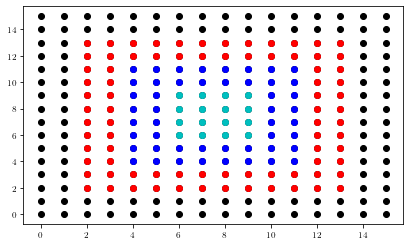

In [154]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_b.square_index(proj_total_g01_b),color='k')
ax.scatter(*params_g01_b.square_index(sub_A_g01_b),color='c')
ax.scatter(*params_g01_b.square_index(sub_B_g01_b),color='r')
ax.scatter(*params_g01_b.square_index(proj_range_g01_b),color='b')

In [155]:
m_list_g01_b=np.linspace(1,3,20)
es_g01_b=50
LN_Born_inf_list_g01_b=np.zeros((len(m_list_g01_b),es_g01_b))
MI_Born_inf_list_g01_b=np.zeros((len(m_list_g01_b),es_g01_b))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_b=[]
for m_i,m in enumerate(m_list_g01_b):
    inputs=[(proj_range_g01_b,sub_A_g01_b,sub_B_g01_b,m) for _ in range(es_g01_b)]
    async_result_g01_b.append(rc[:].map_async(run,inputs))


In [160]:
LN_Born_inf_list_g01_b=[]
for m_i,m in enumerate(m_list_g01_b):
    st=time.time()
    LN_Born_inf_list_g01_b.append(async_result_g01_b[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_b=np.array(LN_Born_inf_list_g01_b)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


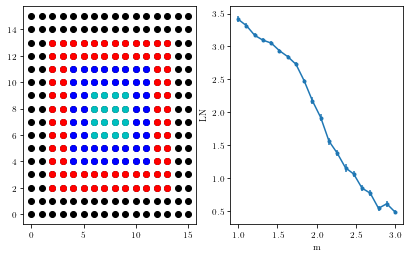

In [161]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_b.square_index(proj_total_g01_b),color='k')
ax[0].scatter(*params_g01_b.square_index(sub_A_g01_b),color='c')
ax[0].scatter(*params_g01_b.square_index(sub_B_g01_b),color='r')
ax[0].scatter(*params_g01_b.square_index(proj_range_g01_b),color='b')
ax[1].errorbar(m_list_g01_b,LN_Born_inf_list_g01_b.mean(axis=1),LN_Born_inf_list_g01_b.std(axis=1)/np.sqrt(es_g01_b-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_inf_g01_b.pdf')

## Finite size

## genus (0,0) --aa

In [5]:
params_g00_aa=Params(m=1,Lx=16,Ly=16)

In [6]:
proj_total_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx),np.arange(params_g00_aa.Ly)],4,proj=True)
ax,ay=4,4
proj_A_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx//4-ax//2,params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly//2-ay//2,params_g00_aa.Ly//2+ay//2)],4,proj=True)
proj_B_g00_aa=params_g00_aa.linearize_index([np.arange(3*params_g00_aa.Lx//4-ax//2,3*params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly)],4,proj=True)
proj_range_g00_aa=np.setdiff1d(proj_total_g00_aa,np.union1d(proj_A_g00_aa,proj_B_g00_aa))
sub_A_g00_aa=params_g00_aa.linearize_index([np.arange(params_g00_aa.Lx//4-ax//2,params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly//2-ay//2,params_g00_aa.Ly//2+ay//2)],4)
sub_B_g00_aa=params_g00_aa.linearize_index([np.arange(3*params_g00_aa.Lx//4-ax//2,3*params_g00_aa.Lx//4+ax//2),np.arange(params_g00_aa.Ly)],4)

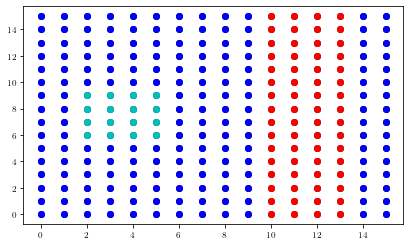

In [7]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_aa.square_index(proj_total_g00_aa),color='k')
ax.scatter(*params_g00_aa.square_index(sub_A_g00_aa),color='c')
ax.scatter(*params_g00_aa.square_index(sub_B_g00_aa),color='r')
ax.scatter(*params_g00_aa.square_index(proj_range_g00_aa),color='b')

In [8]:
m_list_g00_aa=np.linspace(1,3,20)
es_g00_aa=50
LN_Born_inf_list_g00_aa=np.zeros((len(m_list_g00_aa),es_g00_aa))
MI_Born_inf_list_g00_aa=np.zeros((len(m_list_g00_aa),es_g00_aa))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_aa=[]
for m_i,m in enumerate(m_list_g00_aa):
    inputs=[(proj_range_g00_aa,sub_A_g00_aa,sub_B_g00_aa,m) for _ in range(es_g00_aa)]
    async_result_g00_aa.append(rc[:].map_async(run,inputs))


In [29]:
LN_Born_inf_list_g00_aa=[]
for m_i,m in enumerate(m_list_g00_aa):
    st=time.time()
    LN_Born_inf_list_g00_aa.append(async_result_g00_aa[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_aa=np.array(LN_Born_inf_list_g00_aa)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


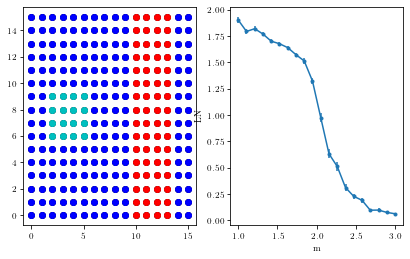

In [30]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_aa.square_index(proj_total_g00_aa),color='k')
ax[0].scatter(*params_g00_aa.square_index(sub_A_g00_aa),color='c')
ax[0].scatter(*params_g00_aa.square_index(sub_B_g00_aa),color='r')
ax[0].scatter(*params_g00_aa.square_index(proj_range_g00_aa),color='b')
ax[1].errorbar(m_list_g00_aa,LN_Born_inf_list_g00_aa.mean(axis=1),LN_Born_inf_list_g00_aa.std(axis=1)/np.sqrt(es_g00_aa-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g00_aa.pdf')

## genus (0,0) --ab

In [107]:
params_g00_ab=Params(m=1,Lx=16,Ly=16,bcx=-1,bcy=1)

In [108]:
proj_total_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx),np.arange(params_g00_ab.Ly)],4,proj=True)
ax,ay=4,4
proj_A_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx//4-ax//2,params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4,proj=True)
proj_B_g00_ab=params_g00_ab.linearize_index([np.arange(3*params_g00_ab.Lx//4-ax//2,3*params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4,proj=True)
proj_range_g00_ab=np.setdiff1d(proj_total_g00_ab,np.union1d(proj_A_g00_ab,proj_B_g00_ab))
sub_A_g00_ab=params_g00_ab.linearize_index([np.arange(params_g00_ab.Lx//4-ax//2,params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4)
sub_B_g00_ab=params_g00_ab.linearize_index([np.arange(3*params_g00_ab.Lx//4-ax//2,3*params_g00_ab.Lx//4+ax//2),np.arange(params_g00_ab.Ly)],4)

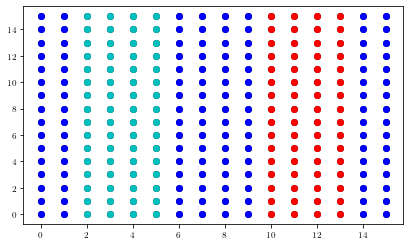

In [109]:
fig,ax=plt.subplots()
ax.scatter(*params_g00_ab.square_index(proj_total_g00_ab),color='k')
ax.scatter(*params_g00_ab.square_index(sub_A_g00_ab),color='c')
ax.scatter(*params_g00_ab.square_index(sub_B_g00_ab),color='r')
ax.scatter(*params_g00_ab.square_index(proj_range_g00_ab),color='b')

In [110]:
m_list_g00_ab=np.linspace(1,3,20)
es_g00_ab=20
LN_Born_inf_list_g00_ab=np.zeros((len(m_list_g00_ab),es_g00_ab))
MI_Born_inf_list_g00_ab=np.zeros((len(m_list_g00_ab),es_g00_ab))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g00_ab=[]
for m_i,m in enumerate(m_list_g00_ab):
    inputs=[(proj_range_g00_ab,sub_A_g00_ab,sub_B_g00_ab,m) for _ in range(es_g00_ab)]
    async_result_g00_ab.append(rc[:].map_async(run,inputs))


In [111]:
LN_Born_inf_list_g00_ab=[]
for m_i,m in enumerate(m_list_g00_ab):
    st=time.time()
    LN_Born_inf_list_g00_ab.append(async_result_g00_ab[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g00_ab=np.array(LN_Born_inf_list_g00_ab)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


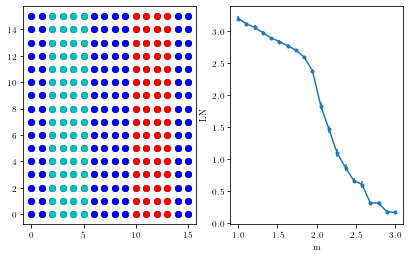

In [32]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g00_ab.square_index(proj_total_g00_ab),color='k')
ax[0].scatter(*params_g00_ab.square_index(sub_A_g00_ab),color='c')
ax[0].scatter(*params_g00_ab.square_index(sub_B_g00_ab),color='r')
ax[0].scatter(*params_g00_ab.square_index(proj_range_g00_ab),color='b')
ax[1].errorbar(m_list_g00_ab,LN_Born_inf_list_g00_ab.mean(axis=1),LN_Born_inf_list_g00_ab.std(axis=1)/np.sqrt(es_g00_ab-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
# fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g00_ab.pdf')

## geneus (0,1) --aa

In [13]:
params_g01_aa=Params(m=1,Lx=16,Ly=16)

In [14]:
proj_total_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx),np.arange(params_g01_aa.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx//4-ax//2,params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly)],4,proj=True)
sub_A_g01_aa=params_g01_aa.linearize_index([np.arange(params_g01_aa.Lx//4-ax//2,params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly)],4)
proj_B_1_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax//2,3*params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly//2-ay//2,params_g01_aa.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax2//2,3*params_g01_aa.Lx//4+ax2//2),np.arange(params_g01_aa.Ly//2-ay2//2,params_g01_aa.Ly//2+ay2//2)],4,proj=True)
proj_B_g01_aa=np.setdiff1d(proj_B_2_g01_aa,proj_B_1_g01_aa)
proj_range_g01_aa=np.setdiff1d(proj_total_g01_aa,np.union1d(proj_A_g01_aa,proj_B_2_g01_aa))

sub_B_1_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax//2,3*params_g01_aa.Lx//4+ax//2),np.arange(params_g01_aa.Ly//2-ay//2,params_g01_aa.Ly//2+ay//2)],4)
sub_B_2_g01_aa=params_g01_aa.linearize_index([np.arange(3*params_g01_aa.Lx//4-ax2//2,3*params_g01_aa.Lx//4+ax2//2),np.arange(params_g01_aa.Ly//2-ay2//2,params_g01_aa.Ly//2+ay2//2)],4)
sub_B_g01_aa=np.setdiff1d(sub_B_2_g01_aa,sub_B_1_g01_aa)


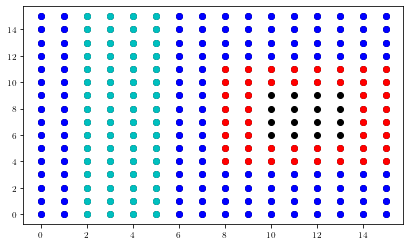

In [15]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_aa.square_index(proj_total_g01_aa),color='k')
ax.scatter(*params_g01_aa.square_index(sub_A_g01_aa),color='c')
ax.scatter(*params_g01_aa.square_index(sub_B_g01_aa),color='r')
ax.scatter(*params_g01_aa.square_index(proj_range_g01_aa),color='b')

In [16]:
m_list_g01_aa=np.linspace(1,3,20)
es_g01_aa=50
LN_Born_inf_list_g01_aa=np.zeros((len(m_list_g01_aa),es_g01_aa))
MI_Born_inf_list_g01_aa=np.zeros((len(m_list_g01_aa),es_g01_aa))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_aa=[]
for m_i,m in enumerate(m_list_g01_aa):
    inputs=[(proj_range_g01_aa,sub_A_g01_aa,sub_B_g01_aa,m) for _ in range(es_g01_aa)]
    async_result_g01_aa.append(rc[:].map_async(run,inputs))


In [33]:
LN_Born_inf_list_g01_aa=[]
for m_i,m in enumerate(m_list_g01_aa):
    st=time.time()
    LN_Born_inf_list_g01_aa.append(async_result_g01_aa[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_aa=np.array(LN_Born_inf_list_g01_aa)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


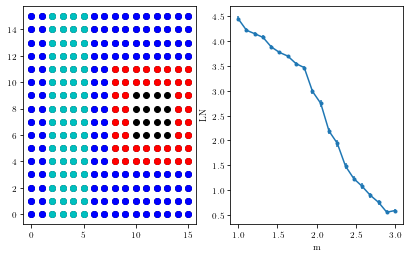

In [34]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_aa.square_index(proj_total_g01_aa),color='k')
ax[0].scatter(*params_g01_aa.square_index(sub_A_g01_aa),color='c')
ax[0].scatter(*params_g01_aa.square_index(sub_B_g01_aa),color='r')
ax[0].scatter(*params_g01_aa.square_index(proj_range_g01_aa),color='b')
ax[1].errorbar(m_list_g01_aa,LN_Born_inf_list_g01_aa.mean(axis=1),LN_Born_inf_list_g01_aa.std(axis=1)/np.sqrt(es_g01_aa-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_aa.pdf')

## geneus (0,1) --ab

In [188]:
params_g01_ab=Params(m=1,Lx=16,Ly=16)

In [189]:
proj_total_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx),np.arange(params_g01_ab.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx//4-ax//2,params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4,proj=True)
sub_A_g01_ab=params_g01_ab.linearize_index([np.arange(params_g01_ab.Lx//4-ax//2,params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4)
proj_B_1_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax//2,3*params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax2//2,3*params_g01_ab.Lx//4+ax2//2),np.arange(params_g01_ab.Ly)],4,proj=True)
proj_B_g01_ab=np.setdiff1d(proj_B_2_g01_ab,proj_B_1_g01_ab)
proj_range_g01_ab=np.setdiff1d(proj_total_g01_ab,np.union1d(proj_A_g01_ab,proj_B_2_g01_ab))

sub_B_1_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax//2,3*params_g01_ab.Lx//4+ax//2),np.arange(params_g01_ab.Ly//2-ay//2,params_g01_ab.Ly//2+ay//2)],4)
sub_B_2_g01_ab=params_g01_ab.linearize_index([np.arange(3*params_g01_ab.Lx//4-ax2//2,3*params_g01_ab.Lx//4+ax2//2),np.arange(params_g01_ab.Ly)],4)
sub_B_g01_ab=np.setdiff1d(sub_B_2_g01_ab,sub_B_1_g01_ab)


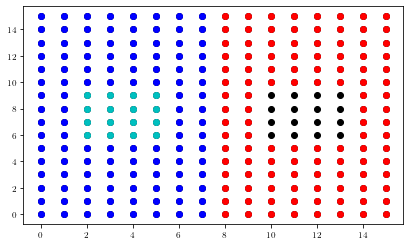

In [190]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ab.square_index(proj_total_g01_ab),color='k')
ax.scatter(*params_g01_ab.square_index(sub_A_g01_ab),color='c')
ax.scatter(*params_g01_ab.square_index(sub_B_g01_ab),color='r')
ax.scatter(*params_g01_ab.square_index(proj_range_g01_ab),color='b')

In [191]:
m_list_g01_ab=np.linspace(1,3,20)
es_g01_ab=50
LN_Born_inf_list_g01_ab=np.zeros((len(m_list_g01_ab),es_g01_ab))
MI_Born_inf_list_g01_ab=np.zeros((len(m_list_g01_ab),es_g01_ab))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ab=[]
for m_i,m in enumerate(m_list_g01_ab):
    inputs=[(proj_range_g01_ab,sub_A_g01_ab,sub_B_g01_ab,m) for _ in range(es_g01_ab)]
    async_result_g01_ab.append(rc[:].map_async(run,inputs))


In [169]:
LN_Born_inf_list_g01_ab=[]
for m_i,m in enumerate(m_list_g01_ab):
    st=time.time()
    LN_Born_inf_list_g01_ab.append(async_result_g01_ab[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ab=np.array(LN_Born_inf_list_g01_ab)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


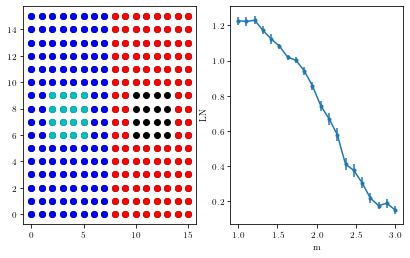

In [170]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ab.square_index(proj_total_g01_ab),color='k')
ax[0].scatter(*params_g01_ab.square_index(sub_A_g01_ab),color='c')
ax[0].scatter(*params_g01_ab.square_index(sub_B_g01_ab),color='r')
ax[0].scatter(*params_g01_ab.square_index(proj_range_g01_ab),color='b')
ax[1].errorbar(m_list_g01_ab,LN_Born_inf_list_g01_ab.mean(axis=1),LN_Born_inf_list_g01_ab.std(axis=1)/np.sqrt(es_g01_ab-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ab.pdf')

## geneus (0,1) --ac

In [192]:
params_g01_ac=Params(m=1,Lx=16,Ly=16)

In [193]:
proj_total_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx),np.arange(params_g01_ac.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
proj_A_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx//4-ax//2,params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly)],4,proj=True)
sub_A_g01_ac=params_g01_ac.linearize_index([np.arange(params_g01_ac.Lx//4-ax//2,params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly)],4)
proj_B_1_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax//2,3*params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly//2-ay//2,params_g01_ac.Ly//2+ay//2)],4,proj=True)
proj_B_2_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax2//2,3*params_g01_ac.Lx//4+ax2//2),np.arange(params_g01_ac.Ly)],4,proj=True)
proj_B_g01_ac=np.setdiff1d(proj_B_2_g01_ac,proj_B_1_g01_ac)
proj_range_g01_ac=np.setdiff1d(proj_total_g01_ac,np.union1d(proj_A_g01_ac,proj_B_2_g01_ac))

sub_B_1_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax//2,3*params_g01_ac.Lx//4+ax//2),np.arange(params_g01_ac.Ly//2-ay//2,params_g01_ac.Ly//2+ay//2)],4)
sub_B_2_g01_ac=params_g01_ac.linearize_index([np.arange(3*params_g01_ac.Lx//4-ax2//2,3*params_g01_ac.Lx//4+ax2//2),np.arange(params_g01_ac.Ly)],4)
sub_B_g01_ac=np.setdiff1d(sub_B_2_g01_ac,sub_B_1_g01_ac)


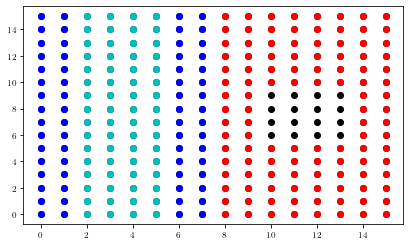

In [194]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ac.square_index(proj_total_g01_ac),color='k')
ax.scatter(*params_g01_ac.square_index(sub_A_g01_ac),color='c')
ax.scatter(*params_g01_ac.square_index(sub_B_g01_ac),color='r')
ax.scatter(*params_g01_ac.square_index(proj_range_g01_ac),color='b')

In [195]:
m_list_g01_ac=np.linspace(1,3,20)
es_g01_ac=50
LN_Born_inf_list_g01_ac=np.zeros((len(m_list_g01_ac),es_g01_ac))
MI_Born_inf_list_g01_ac=np.zeros((len(m_list_g01_ac),es_g01_ac))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ac=[]
for m_i,m in enumerate(m_list_g01_ac):
    inputs=[(proj_range_g01_ac,sub_A_g01_ac,sub_B_g01_ac,m) for _ in range(es_g01_ac)]
    async_result_g01_ac.append(rc[:].map_async(run,inputs))


In [171]:
LN_Born_inf_list_g01_ac=[]
for m_i,m in enumerate(m_list_g01_ac):
    st=time.time()
    LN_Born_inf_list_g01_ac.append(async_result_g01_ac[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ac=np.array(LN_Born_inf_list_g01_ac)


0:0.0
1:0.0
2:0.0
3:0.0
4:0.0
5:0.0
6:0.0
7:0.0
8:0.0
9:0.0
10:0.0
11:0.0
12:0.0
13:0.0
14:0.0
15:0.0
16:0.0
17:0.0
18:0.0
19:0.0


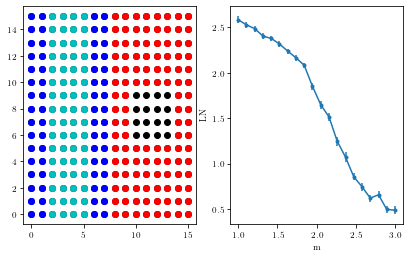

In [172]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ac.square_index(proj_total_g01_ac),color='k')
ax[0].scatter(*params_g01_ac.square_index(sub_A_g01_ac),color='c')
ax[0].scatter(*params_g01_ac.square_index(sub_B_g01_ac),color='r')
ax[0].scatter(*params_g01_ac.square_index(proj_range_g01_ac),color='b')
ax[1].errorbar(m_list_g01_ac,LN_Born_inf_list_g01_ac.mean(axis=1),LN_Born_inf_list_g01_ac.std(axis=1)/np.sqrt(es_g01_ac-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ac.pdf')

## geneus (0,1) --ba

In [196]:
params_g01_ba=Params(m=1,Lx=16,Ly=16)

In [197]:
proj_total_g01_ba=params_g01_ba.linearize_index([np.arange(params_g01_ba.Lx),np.arange(params_g01_ba.Ly)],4,proj=True)
ax,ay=4,4
ax2,ay2=8,8
ax3,ay3=12,12
proj_A_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax//2,2*params_g01_ba.Lx//4+ax//2),np.arange(params_g01_ba.Ly//2-ay//2,params_g01_ba.Ly//2+ay//2)],4,proj=True)
sub_A_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax//2,2*params_g01_ba.Lx//4+ax//2),np.arange(params_g01_ba.Ly//2-ay//2,params_g01_ba.Ly//2+ay//2)],4)

proj_B_1_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax2//2,2*params_g01_ba.Lx//4+ax2//2),np.arange(params_g01_ba.Ly//2-ay2//2,params_g01_ba.Ly//2+ay2//2)],4,proj=True)
proj_B_2_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax3//2,2*params_g01_ba.Lx//4+ax3//2),np.arange(params_g01_ba.Ly)],4,proj=True)
proj_range_g01_ba=np.setdiff1d(proj_B_1_g01_ba,proj_A_g01_ba)

sub_B_1_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax2//2,2*params_g01_ba.Lx//4+ax2//2),np.arange(params_g01_ba.Ly//2-ay2//2,params_g01_ba.Ly//2+ay2//2)],4)
sub_B_2_g01_ba=params_g01_ba.linearize_index([np.arange(2*params_g01_ba.Lx//4-ax3//2,2*params_g01_ba.Lx//4+ax3//2),np.arange(params_g01_ba.Ly)],4)
sub_B_g01_ba=np.setdiff1d(sub_B_2_g01_ba,sub_B_1_g01_ba)


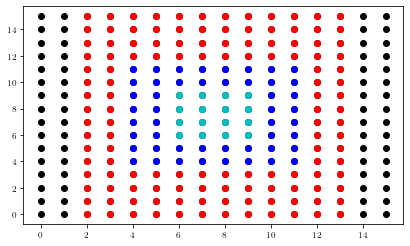

In [198]:
fig,ax=plt.subplots()
ax.scatter(*params_g01_ba.square_index(proj_total_g01_ba),color='k')
ax.scatter(*params_g01_ba.square_index(sub_A_g01_ba),color='c')
ax.scatter(*params_g01_ba.square_index(sub_B_g01_ba),color='r')
ax.scatter(*params_g01_ba.square_index(proj_range_g01_ba),color='b')

In [199]:
m_list_g01_ba=np.linspace(1,3,20)
es_g01_ba=50
LN_Born_inf_list_g01_ba=np.zeros((len(m_list_g01_ba),es_g01_ba))
MI_Born_inf_list_g01_ba=np.zeros((len(m_list_g01_ba),es_g01_ba))
Lx,Ly=16,16

def run(inputs):
    proj_range,sub_A,sub_B,m=inputs
    params=Params(m=m,Lx=16,Ly=16)
    params.measure_all_Born(proj_range,linear=True)
    return params.log_neg(sub_A,sub_B,linear=True)

async_result_g01_ba=[]
for m_i,m in enumerate(m_list_g01_ba):
    inputs=[(proj_range_g01_ba,sub_A_g01_ba,sub_B_g01_ba,m) for _ in range(es_g01_ba)]
    async_result_g01_ba.append(rc[:].map_async(run,inputs))


In [173]:
LN_Born_inf_list_g01_ba=[]
for m_i,m in enumerate(m_list_g01_ba):
    st=time.time()
    LN_Born_inf_list_g01_ba.append(async_result_g01_ba[m_i])
    print('{:d}:{:.1f}'.format(m_i,time.time()-st))
LN_Born_inf_list_g01_ba=np.array(LN_Born_inf_list_g01_ba)


NameError: name 'm_list_g01_ba' is not defined

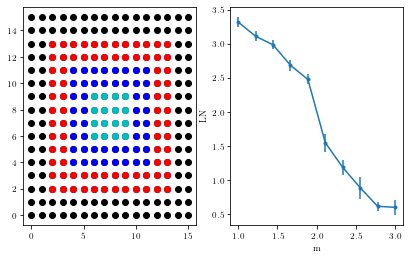

In [45]:
fig,ax=plt.subplots(1,2)
ax[0].scatter(*params_g01_ba.square_index(proj_total_g01_ba),color='k')
ax[0].scatter(*params_g01_ba.square_index(sub_A_g01_ba),color='c')
ax[0].scatter(*params_g01_ba.square_index(sub_B_g01_ba),color='r')
ax[0].scatter(*params_g01_ba.square_index(proj_range_g01_ba),color='b')
ax[1].errorbar(m_list_g01_ba,LN_Born_inf_list_g01_ba.mean(axis=1),LN_Born_inf_list_g01_ba.std(axis=1)/np.sqrt(es_g01_ba-1),fmt='.-')
ax[1].set_xlabel('m')
ax[1].set_ylabel('LN')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/LN_geo_g01_ba.pdf')

# profiler

In [22]:
params=Params(Lx=32,Ly=16,history=False)

In [33]:
def test(A):
    return A+A.T

In [34]:
z=np.random.rand(2048,2048)

In [35]:
%lprun -f test test(z)

Timer unit: 1e-06 s

Total time: 0.072097 s
File: <ipython-input-33-b33413829b27>
Function: test at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test(A):
     2         1      72097.0  72097.0    100.0      return A+A.T

In [37]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-36-933e8321812b>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264                                                   if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266                                                   if not hasattr(self, 's_history'):
   267                                                       self.s_history = []
   268                                                   if not hasattr(self, 'i_history'):
   269                                                       self.i_history = []
   270                                           
   271                                                   mat = self.C_m_history[-1].copy()
   272                                           
   273                                     

In [23]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 29.93 s
File: <ipython-input-20-6f8c91c52c07>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264       256       1244.0      4.9      0.0          if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266       256        532.0      2.1      0.0          if not hasattr(self, 's_history'):
   267         1          1.0      1.0      0.0              self.s_history = []
   268       256        510.0      2.0      0.0          if not hasattr(self, 'i_history'):
   269         1          1.0      1.0      0.0              self.i_history = []
   270                                           
   271       256    2002997.0   7824.2      6.7          mat = self.C_m_history[-1].copy()
   272                                           
   273       768       4359.0      5.7 

In [12]:
%lprun -f Params.bandstructure params.covariance_matrix()

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-9-f4caf49fbcb7>
Function: bandstructure at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def bandstructure(self):
    41                                                   val, vec = nla.eigh(self.Hamiltonian)
    42                                                   sortindex = np.argsort(val)
    43                                                   self.val = val[sortindex]
    44                                                   self.vec = vec[:, sortindex]

In [343]:
%lprun -f Params.c_subregion_m params.c_subregion_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094403 s
File: <ipython-input-310-09246d8612a9>
Function: c_subregion_m at line 146

Line #      Hits         Time  Per Hit   % Time  Line Contents
   146                                               def c_subregion_m(self, subregion, Gamma=None):
   147                                                   '''
   148                                                   subregion: [subregoin_x, subregion_y] index of unit cell
   149                                                   '''
   150         1          2.0      2.0      0.0          if not hasattr(self, 'C_m'):
   151         1      93460.0  93460.0     99.0              self.covariance_matrix()
   152         1          3.0      3.0      0.0          if Gamma is None:
   153         1          2.0      2.0      0.0              Gamma = self.C_m_history[-1]
   154         1          1.0      1.0      0.0          try:
   155         1          5.0      5.0      0.0              subregion = list(sub

In [334]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.11278 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1     107655.0 107655.0     95.5          c_A = self.c_subregion_m(subregion)
   185         1       4908.0   4908.0      4.4          val = nla.eigvalsh(1j*c_A)
   186         1          4.0      4.0      0.0          self.val_sh = val
   187         1         41.0     41.0      0.0          val = np.sort(val)
   188         1         31.0     31.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        141.0    141.0      0.1          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [335]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094029 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1      88525.0  88525.0     94.1          c_A = self.c_subregion_m(subregion)
   185         1       5259.0   5259.0      5.6          val = nla.eigvalsh(1j*c_A)
   186         1          3.0      3.0      0.0          self.val_sh = val
   187         1         37.0     37.0      0.0          val = np.sort(val)
   188         1         47.0     47.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        158.0    158.0      0.2          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [340]:
%lprun -f Params.mutual_information_m params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.037132 s
File: <ipython-input-310-09246d8612a9>
Function: mutual_information_m at line 202

Line #      Hits         Time  Per Hit   % Time  Line Contents
   202                                               def mutual_information_m(self, subregion_A, subregion_B):
   203         1        686.0    686.0      1.8          subregion_A=self.linearize_index(subregion_A,4)
   204         1        407.0    407.0      1.1          subregion_B=self.linearize_index(subregion_B,4)
   205         3        578.0    192.7      1.6          assert np.intersect1d(
   206         2          2.0      1.0      0.0              subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
   207         1       5964.0   5964.0     16.1          s_A = self.von_Neumann_entropy_m(subregion_A)
   208         1       5543.0   5543.0     14.9          s_B = self.von_Neumann_entropy_m(subregion_B)
   209         1        147.0    147.0      0.4          subregion_AB=np.conc

In [331]:
%lprun -f Params.log_neg Params(m=m,Lx=16,Ly=16).log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.202006 s
File: <ipython-input-310-09246d8612a9>
Function: log_neg at line 213

Line #      Hits         Time  Per Hit   % Time  Line Contents
   213                                               def log_neg(self,subregion_A,subregion_B,Gamma=None):
   214         1        333.0    333.0      0.2          subregion_A=self.linearize_index(subregion_A,4)
   215         1        155.0    155.0      0.1          subregion_B=self.linearize_index(subregion_B,4)
   216         1        155.0    155.0      0.1          assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
   217         1          2.0      2.0      0.0          if not hasattr(self,'C_m'):
   218         1      87192.0  87192.0     43.2              self.covariance_matrix()
   219                                                   
   220         1          3.0      3.0      0.0          if Gamma is None:
   221         1          3.0      3.0      0.0             

In [ ]:
# Check scaling behavior